In [1]:
!pip install --upgrade yfinance

In [ ]:
!pip install numpy pandas

In [ ]:
!pip install plotly

# Clean Data

In [1]:
class get_clean_data:

  @classmethod
  def get_data_np_df(cls, symbols , interval = None , period = None, step = '3H', format='pkt' ):
      # symbols = ['BTC-USD' , 'ETH-USD' ]
      if interval == None and period == None :
        interval = '5m'
        period = '1d'

      data = [[0]]  * len(symbols)

      for i , symbol in  enumerate(symbols):
        bar = yf.download(tickers=f'{symbol}' , interval=f'{interval}' , period=f'{period}' )
        data[i] =  bar

      bar_list  = [ symbols , data ]

      bar_list = cls.refined_df ( bar_list, step )


      return bar_list


  @classmethod
  def refined_df(cls, bar_list, step  ):

      symbols   = 0  # index 0 for symbols
      values    = 1  # index 1 for ohlc

      for index, df in enumerate(bar_list[values]):
          df = df.drop('Adj Close', axis=1)
          df = df.drop('Volume', axis =1 )

          # resampled_df = df.resample(step).ohlc()
          # resampled_df = pd.DataFrame(resampled_data)
          np_df = df.to_records(index=True)

          column = []

          for name in np_df.dtype.names:
            if name == 'Datetime':
                column.append('index')
            else:
                column.append(name)

          np_df.dtype.names   = tuple(column)
          np_df['index'] = np_df['index'].astype('datetime64[h]')

          # np_df['index']  =  cls.change_time( date_time_index= np_df['index'] , format= format)
          bar_list[values][index]  =   np_df

      return  bar_list




# Resample Data

In [2]:
from datetime import datetime
import pytz

""""
symbols = [ 'CHFJPY=X'  ]
# symbols = [ 'BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'SOL-USD', 'STETH-USD', 'ADA-USD', 'DOGE-USD', 'TRX-USD', 'LTC-USD' ]

bar_list = get_clean_data.get_data_np_df(symbols , interval = '1H' , period = '7d' )

resample = resample_data( data_list=bar_list , step=4 , rotate = True , format = 'pkt'  )

resample_list = resample.run_resample_data()
# = resample.chart_version( bar_list=bar_list, step=3, rotate = True, format = None )

resample_list

"""
class resample_data:

  def __init__(self, data_list , step = None, rotate = True , format = None  ):

    self.data_list = data_list
    self.step = step
    self.rotate = rotate
    self.format = str(format)

    # self.symbols = 0
    # self.values  = 1

  def run_resample_data(self ):
      bar_list = self.chart_version( bar_list = self.data_list , step= self.step, rotate = self.rotate , format = self.format )

      return bar_list

  def chart_version(self, bar_list, step=3, rotate = True, format = None ):

    symbols = 0  # index 0 for symbols
    values  = 1  # index 1 for ohlc

    if rotate == True:

        if format == 'pkt':
            # Set the time zone to Pakistan Standard Time (Asia/Karachi)
            pakistan_time_zone = pytz.timezone('Asia/Karachi')
            # Get the current time in Pakistan
            current_time = datetime.now(pakistan_time_zone)

        else:
             current_time = datetime.now()

        version    = int(current_time.strftime('%H')) % step

        for index , _ in enumerate (bar_list[values]):

              bar_list[values][index] = bar_list[values][index][version:]
    #   bar_list[values][index] as it is

    bar_list = self.aggregate_interval(bar_list= bar_list , step=step, format= self.format)
    return  bar_list


  def aggregate_interval(self , bar_list, step=3, timezone= None, format = None ):

      # step = 3
      symbols = 0  # index 0 for symbols
      values  = 1  # index 1 for ohlc

      bar_list_resampled = [ [] ] * 2
      bar_list_resampled[symbols] = [[]]  * len(bar_list[symbols])
      bar_list_resampled[values]  = [[]]  * len(bar_list[symbols])

      dt = np.dtype([ ('index', 'datetime64[h]' ), ('symbol', 'object'), ('Open', float), ('High', float), ('Low', float), ('Close', float) ])

      for symbol, ohlc in enumerate(bar_list[values]):

        if format :
          date_index = self.change_time( np.datetime_as_string(ohlc['index'], unit='s'), format= format)

        else :
          date_index = np.array(ohlc['index'] , dtype='datetime64[h]' )


        if step > 1 :
            resampled = date_index[::step]

        elif step == 1 :
            resampled = date_index

        # date_objects = [np.datetime64(date_str) for date_str in resampled ]
        # resampled_dates =  np.array(date_objects, dtype='datetime64[h]')
        select_open  = []
        select_high  = []
        select_low   = []
        select_close = []

        # step = 4 # i = 4 # 4 -4 # 5-4 # 8-4

        for i in range(0, len(bar_list[values][symbol]), step): # logic re solved for 'step' to 'step-1'


            select_open.append(ohlc['Open'][i:i+step][0])
            select_high.append(max(ohlc['High'][i:i+step]))
            select_low.append(min(ohlc['Low'][i:i+step]))
            select_close.append(ohlc['Close'][i:i+step][-1])

        data = np.empty(len(resampled), dtype=dt)

        # return select_close
        # return resampled
        for  i in range(len(resampled)):

            data[i] = ( resampled[i] ,  bar_list[symbols][symbol],   select_open[i],   select_high[i],  select_low[i], select_close[i] )

        bar_list_resampled[values][symbol]  =    data
        bar_list_resampled[symbols][symbol] =  bar_list[symbols][symbol]

      return bar_list_resampled


  def change_time(self, date_time_index, format= None):

      def convert_to_local_time(datetime_str, timezone  ):
          utc_zone = pytz.timezone('UTC')
          timezone_zone = pytz.timezone(f'{timezone}')
          utc_datetime = datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%S')
          utc_datetime = utc_zone.localize(utc_datetime)
          local_datetime = utc_datetime.astimezone(timezone_zone)

          return local_datetime.strftime('%Y-%m-%dT%H:%M:%S')

      if format == 'pkt': timezone = 'Asia/Karachi'
      else :     timezone = 'Asia/Karachi'
      vectorized_conversion = np.vectorize(convert_to_local_time , excluded=['timezone'] )

      converted = vectorized_conversion(date_time_index , timezone=timezone )
      formatted_datetime = np.array( converted , dtype='datetime64[h]' )

      return formatted_datetime


# Indicators

In [111]:
class indicator_store:

  def  shift(self, array , place):

        array   =  np.array(array, dtype= np.float32)
        shifted = np.roll(array, place)
        shifted[0:place]  = np.nan
        shifted[np.isnan(shifted)] = np.nanmean(shifted)

        return shifted

  def  smoothed(self, array, period , alpha = None):

        ema = np.empty_like(array)
        ema = np.full( ema.shape , np.nan)
        ema[0] = np.mean(array[0] , dtype=np.float64)
        if alpha == None:
          alpha = 1 / ( period )

        for i in range(1 , len(array) ):
              ema[i] =  array[i] * alpha +  ( ema[i-1]  * (1-alpha) )
        try: ema =  np.nan_to_num(ema , nan=0)
        except: pass

        return ema

  # def ema (self, array, period ):

  #       ema = np.empty_like(array)
  #       ema = np.full( ema.shape  , np.nan)
  #       ema[0] = np.mean(array[0] , dtype=np.float64)
  #       alpha  = 2 / (period + 1)
  #       # Calculate the EMA for each window of 14 values
  #       for i in range(1 , len(array) ):
  #             ema[i] = np.array( (array[i] * alpha +  ema[i-1]  * (1-alpha) ) , dtype=np.float16 )
  #       try: ema =  np.nan_to_num(ema , nan=0)
  #       except: pass

  #       return ema


  def ema(self, price, period):

        price = np.array(price)
        alpha = 2 / (period + 1.0)
        alpha_reverse = 1 - alpha
        data_length = len(price)

        power_factors = alpha_reverse**(np.arange(data_length+1))

        scale_factors  = 1 / power_factors[:-1]
        initial_offset = price[0] * power_factors[1:]
        weight_factor  = alpha * alpha_reverse**(data_length-1)

        weighted_price_data = price * weight_factor * scale_factors
        cumulative_sums = weighted_price_data.cumsum()
        ema_values = initial_offset + cumulative_sums * scale_factors[::-1]

        return ema_values

  # def shift(self, array , place):

  #     array =  np.array(array, dtype= np.float64)

  #     shifted = np.roll(array, place)
  #     shifted[0:place]  = 0.0
  #     shifted[np.isnan(shifted)] = np.nanmean(shifted)
  #     return shifted

  def sma(self, array, period):

      weights = np.ones(period) / period
      arr     =  np.convolve(array, weights, mode='valid')

      window = period - 1
      sma = np.empty(window + len(arr), dtype=arr.dtype)
      sma[:window] = np.nan * window
      sma[window:] = arr
      sma[np.isnan(sma)] = np.nanmean(arr[:period])

      return sma

    # def sma(self, array, period):

    #   weights = np.ones(period) / period
    #   arr     =  np.convolve(array, weights, mode='valid')

    #   window = period - 1
    #   sma = np.empty(window + len(arr), dtype=arr.dtype)
    #   sma[:window] = np.nan * window
    #   sma[window:] = arr
    #   sma[np.isnan(sma)] = np.nanmean(arr[:period])

    #   return sma

  def moving_min (self, array, period ):
      moving_min = np.empty_like(array)
      moving_min = np.full( moving_min.shape , np.nan)
      for i in range(period, len(array)+1 ):
            moving_min[i-period] = np.min(array[i-period:i]  )
      try: moving_min =  np.nan_to_num(moving_min , nan=0)
      except: pass
      # moving_min[np.isnan(moving_min)] = np.nanmean(moving_min)
      return moving_min

  def moving_max (self, array, period ):
        moving_max = np.empty_like(array)
        moving_max = np.full( moving_max.shape , np.nan )
        # moving_max[:period] = np.max(array[:period])
        for i in range(period, len(array)+1 ):
              moving_max[i-period] = np.max(array[i-period:i]  )
        try: moving_min =  np.nan_to_num(moving_min , nan=0)
        except: pass
        # moving_max[np.isnan(moving_max)] = np.nanmean(moving_max)
        return moving_max

  # def ema (self, array, period ):

  #       ema = np.empty_like(array)
  #       ema = np.full( ema.shape , 0.0)
  #       ema[0] = np.mean(array[0] , dtype=np.float64)
  #       alpha  = 2 / (period + 1)
  #       for i in range(1 , len(array) ):
  #             ema[i] = (array[i] * alpha +  ema[i-1]  * (1-alpha) )

  #       return ema

  # def moving_min (self, array, period ):
  #     moving_min = np.empty_like(array)
  #     moving_min = np.full( moving_min.shape , np.nan)
  #     for i in range(period, len(array)+1 ):
  #           moving_min[i-1] = np.min(array[i-period:i]  )
  #     moving_min[np.isnan(moving_min)] = np.nanmean(moving_min)
  #     return moving_min

  # def moving_max (self, array, period ):
  #       moving_max = np.empty_like(array)
  #       moving_max = np.full( moving_max.shape , np.nan)
  #       for i in range(period, len(array)+1 ):
  #             moving_max[i-1] = np.max(array[i-period:i]  )
  #       moving_max[np.isnan(moving_max)] = np.nanmean(moving_max)
  #       return moving_max

  # def moving_end (self, array, period ):
  #       moving_end = np.empty_like(array)
  #       moving_end = np.full( moving_end.shape , np.nan)

  #       for i in range(period, len(array)+1 ):
  #             moving_end[i-1] = array[i-1:i]
  #       moving_end[np.isnan(moving_end)] = np.nanmean(moving_end)
  #       return moving_end
  # def sma(self, array, period):

  #     weights = np.ones(period) / period
  #     arr     =  np.convolve(array, weights, mode='valid')

  #     window = period - 1
  #     sma = np.empty(window + len(arr), dtype=arr.dtype)
  #     sma[:window] = np.nan * window
  #     sma[window:] = arr
  #     sma[np.isnan(sma)] = np.nanmean(arr[:period])

  #     return sma

# _____________________________________________________________________________

class ema_indicator(indicator_store):

    def __init__(self, data_list = None  ):

        self.data_list = data_list


    def run(self ):

      if self.data_list :
        # constants
        symbols = 0  # index 0 for symbols
        values  = 1  # index 1 for ohlc

        crossover_direction = [[0]]  * len(self.data_list[symbols])

        # crossover_direction_list  = [  bar_list[symbols][name] , crossover_direction ]

        for  symbol, ohlc in enumerate(self.data_list[values]) :

              crossover,  direction     = self.crossover_and_direction( np.array(ohlc['Close'], ohlc['Open']  ) )
              crossover_direction[symbol] =   [crossover,  direction]

        crossover_direction_list  = [  self.data_list[symbols] , crossover_direction ]
        return  crossover_direction_list


    def crossover_and_direction_archived (self, array):

      short_ema  = self.ema(array , 5 )[-1]
      long_ema   = self.ema(array , 20 )[-1]

      # excluding last element from array
      # Caution using third last value for comparision instead second last

      # Experiment for forex pairs : if crossover difficult to detect and show 0 direction we can go with candle index open vs close price
      # if index or candle bullish then upward crossover
      # else if index or candle bearish then downward crossover

      prev_short_ema =   self.ema(array[:-1] , 5 )[-1]
      prev_long_ema  =   self.ema(array[:-1] , 20 )[-1]

      crossover  = direction  = 0

      if prev_short_ema < prev_long_ema and short_ema > long_ema :

            crossover = direction = 1

      elif prev_short_ema > prev_long_ema and short_ema < long_ema :

            crossover = direction = -1

      else:
           if   short_ema > long_ema :
                    direction = 1

           elif short_ema < long_ema  :
                    direction = -1

          #  elif short_ema ==  long_ema  :
          #         direction =

      return  crossover , direction

    # def crossover_direction_lookback(self, bar_list, lookback):

    #     return type(bar_list)  period
    def crossover_and_direction(self, array_close, array_open, ema_period = [5,20] ):
        # ema_period     =  [ 5 , 20 ]
        short_ema  = self.ema(array_close , 5 )[-1]
        long_ema   = self.ema(array_close , 20 )[-1]

        prev_short_ema =   self.ema(array_close[:-1] , ema_period[0] )[-1]
        prev_long_ema  =   self.ema(array_close[:-1] , ema_period[1] )[-1]
        crossover , direction  = 0 , 0

        if prev_short_ema < prev_long_ema and short_ema > long_ema :
              crossover , direction  = 1 , 1

        elif prev_short_ema > prev_long_ema and short_ema < long_ema :
              crossover , direction  = -1 , -1

        else:
            if   short_ema > long_ema :
                      direction = 1

            elif short_ema < long_ema  :
                    direction = -1
            #this means :    long_ema = short_ema True
            elif array_close[-1]  > array_open[-1]  :
                  crossover , direction = 1 , 1
            elif array_open[-1] > array_close[-1]   :
                  crossover, direction = -1 , -1

        return  crossover , direction


    def  ema_lookback(self, bar_list , lookback, ema_period = [5,20] ):

        symbols  = 0
        values   = 1

        emaz_list = [[0]] * len(bar_list[symbols])

        for  symbol , ohlc in enumerate(bar_list[values]):

            emaz = [[0]]  * lookback

            start_index = len(ohlc['Close'])-lookback
            for i in range( (len(ohlc['Close'])-lookback), (len(ohlc['Close'])), 1):

                 short_ema  = self.ema(ohlc['Close'][:i] , ema_period[0] )[-1]
                 long_ema   = self.ema(ohlc['Close'][:i] , ema_period[1] )[-1]
                 emaz[ i-start_index ] = [ short_ema, long_ema ]

            emaz_list[symbol] =  emaz

        return emaz_list


    def crossover_direction_lookback(self, bar_list, ema_period =[5,20], lookback = 10):
        symbols  = 0
        values   = 1

        crossover_direction_list = [[0]] * len(bar_list[symbols])

        for  symbol , ohlc in enumerate(bar_list[values]):

            crossover_direction = [[0]]  * lookback

            start_index = len(ohlc['Close'])-lookback

            for i in range( (len(ohlc['Close'])-lookback), (len(ohlc['Close'])), 1):

                 crossover, direction =  self.crossover_and_direction( ohlc['Close'][:i] , ohlc['Open'][:i], ema_period )
                 crossover_direction[ i-start_index ] = [ crossover, direction ]

            crossover_direction_list[symbol] =  crossover_direction

        return crossover_direction_list



# ema_indicator.transform_data_list(bar_list, lookback, crossover_direction_list  )


#___________________________________________________________________________________________________

class atr_bands_indicator ( ema_indicator):

  def  __init__(self,  data_list= None ):

      self.data_list = data_list
      # , period=8, multiplier= 2.0 , lookback = None

  def  get_atr_bands(self, bar_list, period=5 , multiplier= 1.7  ):

        # constants
        symbols = 0  # index 0 for symbols
        values  = 1  # index 1 for ohlc
        atr_bands = [[0]]  * len(bar_list[symbols])

        for  index, ohlc in enumerate(bar_list[values]) :

              close = ohlc['Close']
              high  = ohlc['High']
              low   = ohlc['Low']

              lower_band,  upper_band   = self.atr_bands( close, high, low, multiplier, period  )

              atr_bands[index]   = [ [lower_band[i],  upper_band[i]] for i in range(len(lower_band)) ]

        atr_bands_list  = [  bar_list[symbols] , atr_bands ]

        return   atr_bands_list


  def  atr_bands(self, close,  high,  low,  multiplier,  period ):

        # multiplier = 2.0 / 1.7
        close_shift = self.shift(close , 1)
        high_low, high_close, low_close  = np.array( high - low ,dtype=np.float32) ,\
        np.array(abs(high - close_shift  ),dtype=np.float32 ) , \
        np.array(abs(low -  close_shift  ),dtype=np.float32 )

        true_range = np.max(np.hstack( (high_low, high_close, low_close) ).reshape(-1,3),axis=1 )
        # true_range[true_range == 0] = 0.0001

        # nan_indices = np.where(np.isnan(true_range))
        mean = np.nanmean(true_range)
        true_range[np.isnan(true_range)] = mean

        # true_range = self.missing_nan(true_range)
        avg_true_range = self.smoothed(true_range, period)

        price =        close
        upper_band =   price + (multiplier * avg_true_range)
        lower_band =   price - (multiplier * avg_true_range)

        return   lower_band , upper_band


  def  atr_bands_lookback(self,  bar_list,  multiplier = 1.7,  period = 5,  lookback = 10 ):

        values   = 1
        symbols  = 0
        atr_bands_list = [[0]] * len(bar_list[symbols])

        for  symbol , ohlc in enumerate(bar_list[values]):

          close = ohlc['Close']
          high  = ohlc['High']
          low   = ohlc['Low']

          lower_band,  upper_band   = self.atr_bands( close, high, low, multiplier, period )

          lower_band = lower_band[-lookback:]
          upper_band = upper_band[-lookback:]

          atr_bands = [ [ lower_band[i], upper_band[i]] for i in range( lookback )]
          atr_bands_list[symbol] =  atr_bands

        return atr_bands_list



#___________________________________________________________________________________________________


import numpy as np

# atr_bands_indicator
# get_atr_bands



# adx = adx_indicator (data_list = bar_list  )
# adx = adx_indicator(bar_list)
# adx_value_list = adx.run_adx()
#

# ___________________________________________________________________________________________________
class adx_indicator( atr_bands_indicator):

  def  __init__(self, data_list = None, period= 14  ):

        self.data_list = data_list
        self.period = period

  def  run_adx(self):

        adx_value_list = self.get_adx(self.data_list, self.period )

        return adx_value_list

  def  get_adx(self, bar_list, period ):

        symbols = 0
        values  = 1
        adx_value = [[0]]  * len(bar_list[symbols])

        for  index, ohlc in enumerate(bar_list[values]) :

              close = ohlc['Close']
              high  = ohlc['High']
              low   = ohlc['Low']
              adx   = self.adx( close, high, low, period )

              adx_value[index]   =  adx

        adx_value_list  = [  bar_list[symbols] , adx_value ]

        return  adx_value_list

  def  adx(self, close, high, low, period = 8 ):

      true_range   = self.true_range( high, low, close  )
      highs , lows =   high - self.shift(high , 1 ) ,  self.shift(low , 1) - low

      pdm = np.where(highs > lows  , highs , 0.0 )
      ndm = np.where(lows  > highs , lows , 0.0  )

      smoothed_atr  = self.smoothed(true_range , period)

      pdi_value =   self.smoothed( pdm , period) / smoothed_atr
      pdi = pdi_value * 100

      ndi_value = self.smoothed( ndm , period) / smoothed_atr
      ndi =  ndi_value * 100

      dx = ( abs(pdi - ndi) ) / ( abs(pdi + ndi) ) * 100
      adx =   self.smoothed(dx, period)

      return adx

  def true_range(self, high, low, close ):

        close_shift = self.shift(close , 1)
        high_low, high_close, low_close  = np.array( high - low ,dtype=np.float32) ,\
        np.array(abs(high - close_shift  ),dtype=np.float32 ) , \
        np.array(abs(low -  close_shift  ) ,dtype=np.float32 )

        true_range = np.max(np.hstack( (high_low, high_close, low_close) ).reshape(-1,3),axis=1 )

        return true_range



  def  adx_lookback(self,   bar_list, period = 8 , lookback = 10):

      symbols  = 0
      values   = 1
      adx_values_list = [[0]] * len(bar_list[symbols])

      for  symbol , ohlc in enumerate(bar_list[values]):

        close = ohlc['Close']
        high  = ohlc['High']
        low   = ohlc['Low']

        adx   = self.adx( close, high, low, period )

        adx_values = adx[-lookback:]

        adx_values_list[symbol] =  adx_values

      return adx_values_list


#___________________________________________________________________________________________________

class heikin_ashi (adx_indicator):

  def __init__(self, refine_list = None):

      self.refine_list = refine_list

  def run_heikin_ashi(self, refine_list ):

      ha_status_list = self.get_heikin_ashi(self, bar_list )

      return  ha_status_list

  def heikin_ashi_status(self, ha_open , ha_close ):

      candles =  np.full_like( ha_close, '', dtype='U10')

      for i in range(1 , len(ha_close) ):

            # green_condition =  ha_close[i] > ha_open[i]
            # red_condition   =  ha_close[i] < ha_open[i]
            if ha_close[i] > ha_open[i] :
              candles[i]  = 'Green'

            elif ha_close[i] < ha_open[i] :
              candles[i]  = 'Red'

            else:
              candles[i] = 'Neutral'

      return  candles


  def heikin_ashi_candles (self, open, high, low, close ):

      ha_low, ha_close =  np.empty(len(close), dtype=np.float32 ), np.empty(len(close), dtype=np.float32 )
      ha_open, ha_high = np.empty(len(close), dtype=np.float32 ),  np.empty(len(close), dtype=np.float32 )


      ha_open[0]  = (open[0] + close[0] ) /2
      ha_close[0] = (close[0] + open[0] + high[0] + low[0]) /4

      for i in range(1 , len(close) ):
            ha_open[i]  = (ha_open[i-1] + ha_close[i-1] ) / 2
            ha_close[i] = (open[i] +  high[i] + low[i] + close[i]) / 4
            ha_high[i]  = max( high[i], ha_open[i], ha_close[i]  )
            ha_low[i]   = min( low[i], ha_open[i], ha_close[i]  )

      return   ha_open, ha_close, ha_high, ha_low


  def get_heikin_ashi (self, bar_list, lookback = None, ohlc_data=None):

      symbols  = 0
      values   = 1
      ha_status_list = [[]] * len(bar_list[symbols])
      ha_ohlc_list   = [[]] * len(bar_list[values])
      # np.empty(len(bar_list[symbols]), dtype='U10')

      for  symbol , ohlc in enumerate(bar_list[values]):

          open, high,  low, close  = ohlc['Open'],  ohlc['High'],  ohlc['Low'], ohlc['Close']

          ha_open, ha_close, ha_high, ha_low   =  self.heikin_ashi_candles( open, high, low, close )
          candles  =  self.heikin_ashi_status(ha_open , ha_close)

          if lookback :
            candles  =  candles[-lookback:]
            ha_open, ha_close, ha_high, ha_low = ha_open[-lookback:], ha_close[-lookback:], ha_high[-lookback:], ha_low[-lookback:]
            # ha_open_close  = [ ha_open[-lookback:] , ha_close[-lookback:] ]

          ha_ohlc_list[symbol]   =  [ha_open, ha_high, ha_low, ha_close]
          ha_status_list[symbol] = candles

      if  ohlc_data == True :

          return ha_ohlc_list

      return ha_status_list

  def normal_to_ha(self, data_list , ha_ohlc_list):

        symbols = 0  # index 0 for symbols
        values  = 1  # index 1 for ohlc

        for  sym, ohlc in enumerate(data_list[values]) :
              ha_open , ha_close = [ element for  element in ha_ohlc_list[sym][0] ], [ element for  element in ha_ohlc_list[sym][3] ]
              ha_high , ha_low   = [ element for  element in ha_ohlc_list[sym][1] ], [ element for  element in ha_ohlc_list[sym][2] ]

              ohlc['Close'], ohlc['Open'] = ha_close  ,  ha_open
              ohlc['High'] , ohlc['Low']  = ha_high   ,  ha_low
              # lower_band,  upper_band   = atr_bands( close, high, low, multiplier, period  )
        return   data_list

#___________________________________________________________________________________________________

class bollinger_bands(heikin_ashi):

  def __init__(self, refine_list = None):

      self.refine_list = refine_list


  def sma(self, array, period):

      weights = np.ones(period) / period
      arr     =  np.convolve(array, weights, mode='valid')

      window = period - 1
      sma = np.empty(window + len(arr), dtype=arr.dtype)
      sma[:window] = np.nan * window
      sma[window:] = arr
      sma[np.isnan(sma)] = np.nanmean(arr[:period])

      return sma


  def std_dev(self, array, period):

      # Calculate the squared deviations from the mean
      squared_deviations = (array - self.sma(array, period ) )**2

      # Calculate the average squared deviations
      average_squared_deviations = self.sma(squared_deviations, period)

      # Calculate the rolling standard deviation
      std_dev = np.sqrt(average_squared_deviations)

      return std_dev

  def run_bollinger_bands(self, refine_list ):

      bollinger_bands_list = self.get_bollinger_bands(bar_list = refine_list )
      return  bollinger_bands_list

  def bollinger_bands(self , high, low, close, period = 20, mult = 2.0   ):

      # bollinger_bands
      typical_price =  (high + low + close) / 3
      typical_price_ma  = self.sma(typical_price, period )
      std_dev =  self.std_dev( typical_price,  period )

      upper_band = typical_price_ma + (mult * std_dev )
      lower_band = typical_price_ma - (mult * std_dev )

      return lower_band , upper_band


  def get_bollinger_bands (self, bar_list, lookback = None ):

      symbols  = 0
      values   = 1
      bollinger_bands_list  =  [[]] * len(bar_list[values])
      # np.empty(len(bar_list[symbols]), dtype='U10')

      for  symbol , ohlc in enumerate(bar_list[values]):

          high,  low,   close      =   ohlc['High'],  ohlc['Low'],  ohlc['Close']
          lower_band , upper_band  =  self.bollinger_bands( high, low, close )

          if lookback :
            lower_band , upper_band    =  lower_band[-lookback:],  upper_band[-lookback:]

          bb_bands = [ [ lower_band[i], upper_band[i]] for i in range( len(lower_band) )]
          bollinger_bands_list[symbol] = bb_bands

      return bollinger_bands_list

class stochastic_oscillator(bollinger_bands):

  def  stochastic_oscillator(self, high, low, close, period):

      # calculate %K line
      # low , high , close  = low.reshape(-1,1) , high.reshape(-1,1) , close.reshape(-1,1)

      lowest_low   = self.moving_min(low  , period )
      highest_high = self.moving_max(high , period )

      k_percent = 100 * ( (   close  - lowest_low) / (highest_high - lowest_low) )
      # calculate %D line
      d_percent = self.sma( k_percent  , 3)

      return  k_percent, d_percent


  def  stochastic_oscillator_lookback(self, bar_list, period = 10, lookback = 10):

      symbols, values = 0, 1
      stochastic_oscillator_list  =  [[]] * len(bar_list[values])
      for index, ohlc in enumerate(bar_list[values]):

          high,  low,   close  =   ohlc['High'],  ohlc['Low'],  ohlc['Close']
          k_percent, d_percent = self.stochastic_oscillator( high, low, close, period)

          if lookback :
            k_percent , d_percent   =  k_percent[-lookback:],  d_percent[-lookback:]

          stochastic_oscillator = [ [ k_percent[i], d_percent[i]] for i in range( len(k_percent) )]
          stochastic_oscillator_list[index] = stochastic_oscillator

      return   stochastic_oscillator_list


class stochastic_momentum_index(stochastic_oscillator):


  def  stochastic_momentum_index(self, high, low, close, period= 20, ema_period = 5):

      lengthD = ema_period
      lowest_low   = self.moving_min(low  , period )
      highest_high = self.moving_max(high , period )
      relative_range   = close - (( highest_high + lowest_low ) / 2 )
      highest_lowest_range = highest_high -   lowest_low

      relative_range_smoothed       = self.smoothed(self.smoothed(relative_range,ema_period),ema_period)
      highest_lowest_range_smoothed = self.smoothed(self.smoothed(highest_lowest_range,ema_period),ema_period)


      smi = [ (relative_range_smoothed[i] / (highest_lowest_range_smoothed[i] / 2)) * 100 if highest_lowest_range_smoothed[i] != 0 else 0.0
              for i in range(len(relative_range_smoothed)) ]

      # relative_range = (lowest_low - highest_high) / highest_lowest_range
      # calculate smi with  %D length

      smi_ema = self.ema(smi,  ema_period)

      return  smi, smi_ema


  def  stochastic_momentum_lookback(self, bar_list, period = 20, lookback = 10, ema_period = 5, crossover_direction= False ):

      symbols, values = 0, 1

      stochastic_momentum_list  =  [[]] * len(bar_list[values])
      stochastic_momentum_crossover_list  = [[]] * len(bar_list[values])
      for index, ohlc in enumerate(bar_list[values]):

          high,  low,   close  =   ohlc['High'],  ohlc['Low'],  ohlc['Close']
          smi, smi_ema = self.stochastic_momentum_index( high, low, close, period, ema_period)
          direction , crossover_values = self.stochastic_momentum_crossover(smi, smi_ema, lookback = lookback)

          if lookback :
            smi, smi_ema   =  smi[-lookback:], smi_ema[-lookback:]

          stochastic_momentum = [ [ smi[i], smi_ema[i]] for i in range( len(smi) )]
          stochastic_momentum_list[index] = stochastic_momentum
          stochastic_momentum_crossover = [ [ direction[i], crossover_values[i]] for i in range( len(direction) )]
          stochastic_momentum_crossover_list[index] = stochastic_momentum_crossover

      if  crossover_direction : return stochastic_momentum_crossover_list

      else : return   stochastic_momentum_list

  def stochastic_momentum_crossover(cls, smi, smi_ema, lookback = 10 ):

        columns, values  = 0, 1

        stochastic_momentum_crossover = [] * len(smi)
        for index, frame in enumerate(bar_df[values]):
          direction = np.where(smi > smi_ema, 1, np.where(smi < smi_ema, -1, 0))

          # Add a new column 'crossover'
          crossover_values = np.where((direction == 1) & (np.roll(direction, 1) == -1), 1, \
                                      np.where((direction == -1) & (np.roll(direction, 1) == 1), -1, 0))
          if lookback :  direction, crossover_values =  direction[-lookback:], crossover_values[-lookback:]

        return  direction , crossover_values

class access_indicators( stochastic_momentum_index ):

        def __init__(self):
            pass




## Stochastic Momentum Index

In [ ]:
def get_pivot_status(self, high, low):

      pivot   =  np.empty(len(low), dtype=object)
      # fractal =  np.empty(len(low))
      # fractal = [[]] *  len(low)

      for i in range (2 , len(low)):

            N = i - 1

            pivot_high  =  high[N] > high[N-1] and high[N] >  high[N+1]
            pivot_low   =  low[N]  < low[N-1]  and low[N]  <  low[N+1]

            if pivot_high  :
                pivot[N] = high[N]

            if pivot_low :
                pivot[N] = low[N]

            else:
                pivot[N] = 0

      return pivot

In [ ]:
import pandas as pd

# Sample data
data = {
    'Day': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'High': [100, 105, 110, 115, 120, 125, 130, 135, 140, 145],
    'Low': [90, 95, 100, 105, 110, 115, 120, 125, 130, 135],
    'PivotHigh': [None] * 10,
    'PivotLow': [None] * 10
}

df = pd.DataFrame(data)

window_size = 3  # Set your desired window size



   Day  High  Low PivotHigh PivotLow
0    1   100   90      None       90
1    2   105   95      None       95
2    3   110  100       110      100
3    4   115  105       115      105
4    5   120  110       120      110
5    6   125  115       125      115
6    7   130  120       130      120
7    8   135  125       135      125
8    9   140  130       140     None
9   10   145  135       145     None


ichimoku_cloud

In [ ]:
# class ichimoku_cloud:

#     def ichimoku_cloud(cls, high, low, close, period = 9, base_period = 26, leading_period = 52 ):


#         high_9, low_9   =  self.moving_min(high, period ), self.moving_min(low  , period )
#         high_26, low_26 =  self.moving_min(high, leading_period ), self.moving_min(low, leading_period )
#         high_52, low_52 =  self.moving_min(high, leading_period ), self.moving_min(low, leading_period )

#         conversion_line =  (high_9 + low_9) / 2
#         base_line       =  (high_26 + low_26) / 2
#         a_              =  (conversion_line + base_line) / 2
#         leading_span_a  =  np.roll(a_, 26)

#         b_              =   (high_52 + low_52) / 2
#         leading_span _b =   np.roll(b_, 26)

#         lagging_span = np.roll(close,-26)

0

In [ ]:
my_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Iterate over the list in a loop style
for i in range(len(my_list) - 3, -1, -2):
    print("Last two values:", my_list[i+1], my_list[i])

# Note: This assumes that the list has at least four elements.


Last two values: 8 7
Last two values: 6 5
Last two values: 4 3
Last two values: 2 1


In [ ]:
# Example list
low = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

pivot_low =  [0] * len(low)
# Create a new list with every third element
# new_list = my_list[::-2]
period = 2
pivot_low[0] = low[0]

for i in range(len(low), len(low)%period,  -period ):
      # print("index",i-period,"->",i,": values",low[i-period:i])
      # chose  = low[i-period:i]
      idx =  min(low[i-period:i])
      print(idx)


9


index 9 -> 5 : values [9]
index 5 -> 1 : values [5]
index 1 -> -3 : values [1]


In [ ]:
high = [100, 105, 110, 115, 120, 125, 130, 135, 140, 145]
low  = [90, 95, 100, 105, 110, 115, 120, 125, 130, 135]



# LOOKBACK CLASS


In [118]:
"""
bar_df = indicators_lookback_mode.transform_data_list( refine_list = refined_list, multiplier= 1.7 , atr_period = 5,  adx_period = 8 ,   lookback = 1  , ha_ohlc = True)
print(bar_df)

"""
from numpy.lib.recfunctions import append_fields

class  indicators_lookback_mode( access_indicators ):

  @classmethod
  def transform_data_list(cls, refine_list ,  multiplier= 1.7 , atr_period = 5,  adx_period = 8,   lookback = 10, ema_period = [5, 20], ha_ohlc = True ):

    symbols   = 0
    values    = 1
    indicator = cls() # universal class of project => adx_indicator

    heikin_ashi = indicator.get_heikin_ashi (bar_list = refine_list,  ohlc_data=True)

    # crossover_direction_list  =  adx_atr_bands_indicator.crossover_direction_lookback(bar_list = refine_list, lookback = lookback )
    ha_status_list = indicator.get_heikin_ashi ( refine_list, lookback = lookback)
    if ha_ohlc :
      refine_list = indicator.normal_to_ha(data_list = refine_list, ha_ohlc_list = heikin_ashi )

    ha_ohlc_list = indicator.get_heikin_ashi (bar_list = refine_list, lookback = lookback, ohlc_data=True)

    crossover_direction_list   =  indicator.crossover_direction_lookback(bar_list = refine_list, ema_period = ema_period ,lookback = lookback )

    stochastic_momentum_list =  indicator.stochastic_momentum_lookback( bar_list = refine_list, period = ema_period[1], lookback = lookback, ema_period = ema_period[0])

    stochastic_momentum_crossover_list = indicator.stochastic_momentum_lookback( bar_list = refine_list, period = ema_period[1], lookback = lookback, ema_period = ema_period[0], crossover_direction=True)
    emaz_list  =  indicator.ema_lookback( bar_list = refine_list, lookback = lookback , ema_period = ema_period )

    atr_bands_list = indicator.atr_bands_lookback( refine_list , multiplier,  period = atr_period ,  lookback = lookback  )
    adx_value_list = indicator.adx_lookback( bar_list = refine_list,   period = adx_period , lookback = lookback)


    bollinger_bands_list = indicator.get_bollinger_bands( bar_list, lookback = lookback )

    # lookback = 10
    dt   = np.dtype([ ('index', 'datetime64[h]'),  ('symbol', 'U20'), ('Open', float ), ('High', float ), ('Low', float),  ('Close', float ),  ('Heikin-Ashi-Status', 'U10'),  ('Direction', float), ('Average-Directional-Index', float), ('Crossover', float),   \
        ('Stop_Loss', float), ('Take_Profit', float), ('direction_smi', float), ('crossover_smi', float), ('ema_low', float), ('ema_high', float), ('smi', float), ('smi_ema', float), ('bb_lower', float ), ('bb_upper', float), ('atr_lower', float), ('atr_upper', float ), ('ha_open', float), ('ha_high', float),('ha_low', float),('ha_close', float)  ])


    column_names = dt.names
    data = [[0]]  * len(refine_list[symbols])

    for sym , ohlc in enumerate(refine_list[values]):

            index  = ohlc['index'][-lookback:]
            symbol = ohlc['symbol'][-lookback:]
            open   = ohlc['Open'][-lookback:]
            high   = ohlc['High'][-lookback:]
            low    = ohlc['Low'][-lookback:]
            close  = ohlc['Close'][-lookback:]

            heikin_ashi_status = [  element for element in ha_status_list[sym]  ]

            # fractal_status  = [ element  for  element in ha_ohlc_list[sym]  ]
            ha_open , ha_close = [ element for  element in ha_ohlc_list[sym][0] ], [ element for  element in ha_ohlc_list[sym][3] ]
            ha_high , ha_low   = [ element for  element in ha_ohlc_list[sym][1] ], [ element for  element in ha_ohlc_list[sym][2] ]

            smi =     [ element[0] for element in stochastic_momentum_list[sym] ]
            smi_ema = [ element[1] for element in stochastic_momentum_list[sym] ]

            direction_smi        = [ element[0] for element in stochastic_momentum_crossover_list[sym] ]
            crossover_smi = [ element[1] for element in stochastic_momentum_crossover_list[sym] ]


            adx_value  = [  element    for element in adx_value_list[sym]  ]
            lower_band = [  element[0] for element in atr_bands_list[sym]  ]
            upper_band = [  element[1] for element in atr_bands_list[sym]  ]

            bb_lower = [  element[0] for element in bollinger_bands_list[sym]  ]
            bb_upper = [  element[1] for element in bollinger_bands_list[sym]  ]
            bb_bands = [ bb_lower,  bb_upper ]
            # crossover =   crossover_direction_list[index][dynamic--for next values of crossover of date time index][0-->static for crossover]
            crossover = [ element[0] for element in crossover_direction_list[sym] ]
            direction = [ element[1] for element in crossover_direction_list[sym] ]

            short_ema = [ element[0] for element in emaz_list[sym] ]
            long_ema  = [ element[1] for element in emaz_list[sym] ]
            # ha_ohlc_list[symbol]   =  [ha_open, ha_high, ha_low, ha_close]
            ha_ohlc = [ element for  element in  ha_ohlc_list[sym] ]

            ohlc_df = np.empty(len(close), dtype=dt)

            for i in range(0 , len(ohlc_df)):

                stop_loss   = 0
                take_profit = 0
                if crossover[i] == 1  or  direction[i] == 1 :
                      stop_loss   = lower_band[i]
                      take_profit = upper_band[i]

                elif crossover[i] == -1  or  direction[i] == -1 :
                      stop_loss   = upper_band[i]
                      take_profit = lower_band[i]

                ohlc_df[i] = ( index[i], symbol[i], open[i], high[i], low[i], close[i], heikin_ashi_status[i], direction[i], adx_value[i], \
                               crossover[i], stop_loss, take_profit, direction_smi[i] , crossover_smi[i],  short_ema[i], long_ema[i], smi[i], smi_ema[i],  bb_lower[i], bb_upper[i], lower_band[i], upper_band[i], ha_open[i], ha_high[i] , ha_low[i], ha_close[i]  )
#

            data[sym] = ohlc_df

    return [column_names, data]



class stochastic_momentum_crossover:
    @classmethod
    def stochastic_momentum_crossover(cls, bar_df ):
        columns, values  =  0 , 1
        sort_index, signal_list = [] , []
        for index, frame in enumerate(bar_df[values]):
          direction = np.where(frame['smi'] > frame['smi_ema'], 1, np.where(frame['smi'] < frame['smi_ema'], -1, 0))
          frame = np.lib.recfunctions.append_fields(frame, 'direction_smi', direction, usemask=False)
          # Add a new column 'crossover'
          crossover_values = np.where((frame['direction_smi'] == 1) & (np.roll(frame['direction_smi'], 1) == -1), 1, \
                                      np.where((frame['direction_smi'] == -1) & (np.roll(frame['direction_smi'], 1) == 1), -1, 0))
          frame    = np.lib.recfunctions.append_fields(frame, 'crossover_smi', crossover_values, usemask=False)
          # bar_df[values][index]  = ohlc
        smi_direction_crossover  = [ 'direction_smi', 'crossover_smi' ]
        column_names = list(bar_df[columns])
        column_names.extend(smi_direction_crossover )

        return [column_names, bar_df[values]]


In [32]:
my_list = ["first"]
strings_to_append = ["second", "third", "fourth"]

my_list.extend(strings_to_append)

print(my_list)


['first', 'second', 'third', 'fourth']


# Run

In [128]:
"""
# symbols = [ 'CHFJPY=X'  ]
# # symbols = [ 'BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'SOL-USD', 'STETH-USD', 'ADA-USD', 'DOGE-USD', 'TRX-USD', 'LTC-USD' ]
# bar_list = get_clean_data.get_data_np_df(symbols , interval = '1H' , period = '7d' )
# resample = resample_data( data_list=bar_list , step=4 , rotate = True , format = 'pkt'  )
#refine.chart_version( bar_list=bar_list, step=3, rotate = True, format = None )

# resample_list = resample.run_resample_data()
# # OR
# refine_list = resample.run_resample_data()
# resample_list
# bar_df = indicators_lookback_mode.transform_data_list( refine_list = resample_list, multiplier= 1.7 , atr_period = 5,  adx_period = 8 ,   lookback = 10  )
# print(bar_df)
                """
"""
adx_perriod = 8  --> 4 Hour Timeframe
adx_perriod = 10 --> 1 Hour Timeframe
"""
# ema_period     =  [ 5 , 20 ]
import yfinance as yf

symbols_forex = [
    'AUDCAD=X', 'AUDCHF=X', 'AUDJPY=X', 'AUDNZD=X', 'AUDUSD=X',
    'CADCHF=X','CADJPY=X' ,
    'CHFJPY=X',
    'EURAUD=X', 'EURCAD=X', 'EURCHF=X', 'EURGBP=X', 'EURJPY=X', 'EURNZD=X', 'EURUSD=X',
    'GBPAUD=X', 'GBPCAD=X', 'GBPCHF=X', 'GBPJPY=X', 'GBPUSD=X',  'GBPNZD=X',
    'NZDCAD=X', 'NZDCHF=X', 'NZDJPY=X', 'NZDUSD=X',
    'USDCHF=X', 'USDCAD=X', 'USDJPY=X'
]

# symbols = [ 'BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'SOL-USD', 'STETH-USD', 'ADA-USD', 'DOGE-USD', 'TRX-USD', 'LTC-USD' ]
# symbols = [ 'BTC-USD', 'ETH-USD' ]

chart = '1H'
step  =  1
chart_type = str(int( int(chart[0]) * step)) + str(f"{chart[-1]}")

# symbols = [ 'CHFJPY=X'  ]
bar_list = get_clean_data.get_data_np_df(symbols= symbols_forex , interval = '1H' , period = '7d' )

# resample = resample_data( data_list=bar_list , step=4 , rotate = True , format = 'pkt'  )
resample = resample_data( data_list=bar_list , step=1 , rotate = False , format = 'pkt'  )

resample_list = resample.run_resample_data()

bar_df = indicators_lookback_mode.transform_data_list( refine_list = resample_list, multiplier= 1.7 ,\
                  atr_period = 5, adx_period = 8 , lookback = 14, ema_period = [5, 20] , ha_ohlc = True )
# , ha_ohlc = True


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [129]:
bar_df = indicators_lookback_mode.transform_data_list( refine_list = resample_list, multiplier= 1.7 ,\
                  atr_period = 5, adx_period = 8 , lookback = 30, ema_period = [5, 20] , ha_ohlc = False )



## RUN FOR SORTING

In [146]:
chart = '1H'
step  =  1
chart_type = str(int( int(chart[0]) * step)) + str(f"{chart[-1]}")


sell_sorted_data, sell_signal_list = sorting.stochastic_momentum_downtrend( bar_df, last_candles = 25, cross_only= False , chart_type =chart_type)
buy_sorted_data, buy_signal_list   = sorting.stochastic_momentum_uptrend( bar_df, last_candles = 25, cross_only= True , chart_type =chart_type)


# signal_list
buy_signal_list


[['AUDJPY=X',
  'sell',
  95.59845856255022,
  95.0745455878404,
  numpy.datetime64('2023-12-15T05','h'),
  '1H'],
 ['USDJPY=X',
  'sell',
  149.41433442103127,
  135.16467558873435,
  numpy.datetime64('2023-12-15T05','h'),
  '1H']]

In [142]:
sell_sorted_data

[]

In [162]:
buy_sorted_data_breakout, buy_signal_list_breakout  = sorting.sort_uptrend_breakout(bar_df, last_candles = 25 , chart_type =chart_type)


buy_sorted_data_breakout

[25, 0]

In [163]:
buy_signal_list_breakout

25

In [152]:
buy_signal_list_breakout

[['AUDJPY=X',
  'buy',
  94.64672111617826,
  95.34128547561862,
  numpy.datetime64('2023-12-15T03','h'),
  '1H'],
 ['USDJPY=X',
  'buy',
  139.0172792710488,
  144.89772927387307,
  numpy.datetime64('2023-12-15T11','h'),
  '1H']]

In [132]:
buy_signal_list

[['AUDJPY=X',
  'sell',
  95.59845856255022,
  95.0745455878404,
  numpy.datetime64('2023-12-15T05','h'),
  '1H'],
 ['USDJPY=X',
  'sell',
  149.41433442103127,
  135.16467558873435,
  numpy.datetime64('2023-12-15T05','h'),
  '1H']]

In [126]:
import pickle


# Specify the file path
file_path = 'bar_df.bin'

# Writing the list to a binary file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(bar_df, file)

print(f'The list has been stored in {file_path}')


The list has been stored in bar_df.bin


In [ ]:
# heikin ashi
z = bar_df[1][0]['smi_ema'][-5]
print(z)

99.999999997764


In [94]:

print(bar_df[1][0]['smi'][-1], bar_df[1][0]['smi_ema'][-1])



53.512207419508876 53.46875


In [120]:

print(bar_df[1][0]['smi'][-1], bar_df[1][0]['smi_ema'][-1])



47.9969115573679 47.99735169152052


# Sorting

In [161]:
import numpy as np
from numpy.lib.recfunctions import append_fields

class sorting :
    # define numpy structured array structure
    columns, values = 0 , 1

    @classmethod
    def get_signal_data(cls, matches, order_type):

      symbol = matches['symbol'][0]

      if order_type == 1 :
         order       = 'buy'
         stop_loss   =  matches['atr_lower'][0]
         take_profit =  matches['atr_upper'][0]

      elif order_type == -1 :
         order       = 'sell'
         stop_loss   =  matches['atr_upper'][0]
         take_profit =  matches['atr_lower'][0]

      time  = matches['index'][0]
      return  symbol, order, stop_loss, take_profit, time


    @classmethod
    def sort_uptrend_breakout(cls, bar_df, last_candles = 10,  chart_type = None ):

      sort_index, signal_list  =  [], []
      for index, ohlc in enumerate(bar_df[sorting.values]):

          observe = ohlc[-last_candles:]

          volatile_adx = (observe['Average-Directional-Index'] > 18) & (observe['Average-Directional-Index'] < 25)

          uptrend_bb_band     = observe[(observe['High'] > observe['bb_upper']) | (observe['Close'] > observe['bb_upper']) ]
          uptrend_heikin_ashi = observe['Heikin-Ashi-Status'] == 'Green'

          return  [ len(volatile_adx) , len(uptrend_bb_band) ,  ] , len(uptrend_heikin_ashi)

          find    = volatile_adx and uptrend_bb_band and uptrend_heikin_ashi

          matches = observe[find]
          if  len(matches) > 0 :
              sort_index.append(index)
              symbol, order, stop_loss, take_profit, time  =  cls.get_signal_data( matches, order_type = 1 )
              signal  =  [symbol, order, stop_loss, take_profit, time, chart_type ]
              signal_list.append(signal)

      sorted_data = [ bar_df[sorting.values][i] for i in range(len(bar_df[sorting.values])) if i in sort_index ]

      return sorted_data, signal_list


    @classmethod
    def sort_downtrend_breakout(cls, bar_df, last_candles = 10,  chart_type = None ):

      sort_index, signal_list  =  [], []

      for index, ohlc in enumerate(bar_df[sorting.values]):

          observe = ohlc[-last_candles:]

          volatile_adx = (observe['Average-Directional-Index'] > 18) &  (observe['Average-Directional-Index'] < 25)
          downtrend_bb_band      = (observe['Low'] < observe['bb_lower']) | (observe['Close'] < observe['bb_lower'])
          downtrend_heikin_ashi  = observe['Heikin-Ashi-Status'] == 'Red'

          find    = volatile_adx and downtrend_bb_band and downtrend_heikin_ashi
          matches = observe[find]
          if  len(matches) > 0 :
              sort_index.append(index)
              symbol, order, stop_loss, take_profit, time  =  cls.get_signal_data( matches, order_type = -1 )
              signal  =  [symbol, order, stop_loss, take_profit, time, chart_type ]
              signal_list.append(signal)

      sorted_data = [ bar_df[sorting.values][i] for i in range(len(bar_df[sorting.values])) if i in sort_index ]

      return sorted_data, signal_list


    @classmethod
    def sort_uptrend_crossover(cls, bar_df, last_candles = 10,  chart_type = None ):


      sort_index, signal_list  =  [], []
      for index, ohlc in enumerate(bar_df[sorting.values]):

          observe = ohlc[-last_candles:]

          volatile_adx = (observe['Average-Directional-Index'] > 18) &  (observe['Average-Directional-Index'] < 25)
          mask_uptrend_crossover  = observe['Crossover'] == 1
          uptrend_heikin_ashi = observe['Heikin-Ashi-Status'] == 'Green'

          find    =  volatile_adx & mask_uptrend_crossover & uptrend_heikin_ashi
          matches =  observe[find]
          if  len(matches) > 0 :
              sort_index.append(index)
              symbol, order, stop_loss, take_profit, time  =  cls.get_signal_data( matches, order_type = 1 )
              signal  =  [symbol, order, stop_loss, take_profit, time, chart_type ]
              signal_list.append(signal)

      sorted_data = [ bar_df[sorting.values][i] for i in range(len(bar_df[sorting.values])) if i in sort_index ]

      return sorted_data, signal_list

    @classmethod
    def sort_downtrend_crossover(cls, bar_df,  last_candles=10,  chart_type = None ):

      sort_index, signal_list  =  [], []
      for index, ohlc in enumerate(bar_df[sorting.values]):

          observe = ohlc[-last_candles:]

          volatile_adx = (observe['Average-Directional-Index'] > 18) &  (observe['Average-Directional-Index'] < 25)
          mask_downtrend_crossover  = observe['Crossover'] == -1
          downtrend_heikin_ashi  = observe['Heikin-Ashi-Status'] == 'Red'

          find    = volatile_adx & mask_downtrend_crossover & downtrend_heikin_ashi
          matches = observe[find]
          if  len(matches) > 0 :
              sort_index.append(index)
              symbol, order, stop_loss, take_profit, time  =  cls.get_signal_data( matches, order_type = -1 )
              signal  =  [symbol, order, stop_loss, take_profit, time, chart_type ]
              signal_list.append(signal)
      sorted_data = [ bar_df[sorting.values][i] for i in range(len(bar_df[sorting.values])) if i in sort_index ]

      return sorted_data, signal_list


    @classmethod
    def  stochastic_momentum_uptrend(cls, bar_df, last_candles = 10, cross_only= True , chart_type = None ):

      sort_index, signal_list = [] , []
      for index, ohlc in enumerate(bar_df[sorting.values]):

        observe = ohlc[-last_candles:]

        volatile_adx = (observe['Average-Directional-Index'] > 18) & (observe['Average-Directional-Index'] < 25)
        mask_downtrend_crossover  = observe['crossover_smi']   == 1
        downtrend_heikin_ashi  = observe['Heikin-Ashi-Status'] == 'Green'

        if cross_only:  find   =                mask_downtrend_crossover
        else :          find   = volatile_adx & mask_downtrend_crossover & downtrend_heikin_ashi
        matches = observe[find]
        if  len(matches) > 0 :
              sort_index.append(index)
              symbol, order, stop_loss, take_profit, time  =  cls.get_signal_data( matches, order_type = -1 )
              signal  =  [symbol, order, stop_loss, take_profit, time, chart_type]
              signal_list.append(signal)

      sorted_data = [ bar_df[sorting.values][i] for i in range(len(bar_df[sorting.values])) if i in sort_index ]

      return sorted_data, signal_list

    @classmethod
    def  stochastic_momentum_downtrend(cls, bar_df, last_candles = 10, cross_only= True, chart_type = None ):

      sort_index, signal_list = [] , []
      for index, ohlc in enumerate(bar_df[sorting.values]):

        observe = ohlc[-last_candles:]

        volatile_adx = (observe['Average-Directional-Index'] > 18) & (observe['Average-Directional-Index'] < 25)
        mask_downtrend_crossover  = observe['crossover_smi'] == -1
        downtrend_heikin_ashi  = observe['Heikin-Ashi-Status'] == 'Red'

        if cross_only:  find   =                mask_downtrend_crossover
        else :          find   = volatile_adx & mask_downtrend_crossover & downtrend_heikin_ashi
        matches = observe[find]
        if  len(matches) > 0 :
              sort_index.append(index)
              symbol, order, stop_loss, take_profit, time  =  cls.get_signal_data( matches, order_type = -1 )
              signal  =  [symbol, order, stop_loss, take_profit, time, chart_type]
              signal_list.append(signal)

      sorted_data = [ bar_df[sorting.values][i] for i in range(len(bar_df[sorting.values])) if i in sort_index ]

      return sorted_data, signal_list

    @classmethod
    def sort_trend_change_early_exit(cls, bar_df,   last_candles = 10  ):

      sort_index, signal_list, comments = [] , [] , []
      for index, ohlc in enumerate(bar_df[sorting.values]):

          observe = ohlc[-last_candles:]

          # Filter based on Average Directional Index (ADX)
          volatile_adx = observe['Average-Directional-Index'] > 20

          mask_downtrend_crossover  = observe['Crossover'] == -1
          mask_uptrend_crossover    = observe['Crossover'] ==  1
          down =  np.where(mask_downtrend_crossover)
          up   =  np.where(mask_uptrend_crossover)
          # np.where

          # Combine filters using logical AND
          matches = observe[volatile_adx & mask_downtrend_crossover]
          symbol = observe['symbol'][0]

          if  len(up) > 1 or len(down) > 1 :
                  sort_index.append(index)

                  if up[0] < down[0]:   comments.append(f" Uptrend came at {observe['index'][up[0]]} but downward-crossover changed situation")
                  else: comments.append(f" Downtrend came at {observe['index'][down[0]]} but upward-crossover changed situation")


                  if up[0] != up[-1] or down[0] != down[-1]:

                    comments.append(f" Use Higher TimeFrame With 200 EMA/50 and ADX 20 period")

                    if up[-1] < down[-1]:  comments.append(f" Downtrend came at {observe['index'][down[-1]]} situation changed may close buy\
                                                          trades after seeing chart, adx status and heikin ashi candles")

                    if up[-1] > down[-1]:  comments.append(f" Uptrend came at {observe['index'][up[-1]]} situation changed may close sell\
                                                          trades after seeing chart, adx status and heikin ashi candles")
                    signal = [ symbol, comments ]
                    signal_list.append(signal)


          elif  len(up) == 1 and len(down) != 0 :
                  sort_index.append(index)
                  comments.append(f" One up-crossover  Use Higher TimeFrame With 200 EMA/50 and ADX 20 period")

                  if up[0] < down[0]:   comments.append(f" Uptrend came at {observe['index'][up[0]]} but downward-crossover changed situation")
                  else: comments.append(f" Downtrend came at {observe['index'][down[0]]} but upward-crossover changed situation")

                  if up[0] != up[-1] or down[0] != down[-1]:
                      comments.append(f" Use Higher TimeFrame With 200 EMA/50 and ADX 20 period")

                      if up[-1] < down[-1]:  comments.append(f" Downtrend came at {observe['index'][down[-1]]} situation changed may close buy\
                                                            trades after seeing chart, adx status and heikin ashi candles")
                      if up[-1] > down[-1]:  comments.append(f" Uptrend came at {observe['index'][up[-1]]} situation changed may close sell\
                                                            trades after seeing chart, adx status and heikin ashi candles")
                  signal = [ symbol, comments ]
                  signal_list.append(signal)


          elif  len(down) == 1 and len(up) != 0 :
                  sort_index.append(index)
                  comments.append(f" One down-crossover and tried   Use Higher TimeFrame With 200 EMA/50 and ADX 20 period")

                  if up[0] < down[0]:   comments.append(f" Uptrend came at {observe['index'][up[0]]} but downward-crossover changed situation")
                  else: comments.append(f" Downtrend came at {observe['index'][down[0]]} but upward-crossover changed situation")

                  if up[0] != up[-1] or down[0] != down[-1]: comments.append(f" Use Higher TimeFrame With 200 EMA/50 and ADX 20 period")

                  if up[-1] < down[-1]:  comments.append(f" Downtrend came at {observe['index'][down[-1]]} situation changed may close buy\
                                                         trades after seeing chart, adx status and heikin ashi candles")
                  if up[-1] > down[-1]:  comments.append(f" Uptrend came at {observe['index'][up[-1]]} situation changed may close sell\
                                                         trades after seeing chart, adx status and heikin ashi candles")
                  signal = [ symbol, comments ]
                  signal_list.append(signal)

          else:
                  continue
      sorted_data = [ bar_df[sorting.values][i] for i in range(len(bar_df[sorting.values])) if i in sort_index ]

      return sorted_data, signal_list

In [67]:
chart_type

1

[['BTC-USD',
  'sell',
  42356.18656685639,
  41405.50093314361,
  numpy.datetime64('2023-12-17T08','h'),
  '1H']]

In [ ]:
print(sorted_data[0]['smi'], sorted_data[0]['smi_ema'])
# sorted_data[0]

In [80]:
chart = '1H'
step  =  1
chart_type = str(int( int(chart[0]) * step)) + str(f"{chart[-1]}")


sorted_data, signal_list = sorting.stochastic_momentum_downtrend( bar_df, last_candles = 10, cross_only= True , chart_type =chart_type)
signal_list


[['BTC-USD',
  'sell',
  42323.80396430641,
  41595.64916069359,
  numpy.datetime64('2023-12-17T23','h'),
  '1H']]

For Acitive Orders Early Exit / For Trend Change Early Alert

In [ ]:
def sort_trend_change_early_exit(cls, bar_df,   last_candles = 10  ):

      sort_index = []
      for index, ohlc in enumerate(bar_df[sorting.values]):

          last_candles = 3
          observe = ohlc[-3:]

          # Filter based on Average Directional Index (ADX)
          mask_adx = observe['Average-Directional-Index'] > 19

          # Filter based on Stochastic Oscillator
          # mask_stochastic = observe['Stochastic-Oscillator'] < 20
          mask_downtrend_crossover  = observe[ (observe['Crossover'] == -1) & (observe['Crossover'] == 1) ]

          # Combine filters using logical AND

          matches = observe[mask_adx & mask_downtrend_crossover]
          if  len(matches) > 0 :  sort_index.append(index)

          # print(index, filtered_data)
      # Using list comprehension
      sorted_data = [ bar_df[values][i] for i in range(len(bar_df[sorting.values])) if i in sort_index ]

      return sorted_data



2

# Get Signal

In [ ]:
bar_df

[('index',
  'symbol',
  'Open',
  'High',
  'Low',
  'Close',
  'Heikin-Ashi-Status',
  'Direction',
  'Average-Directional-Index',
  'Crossover',
  'Stop_Loss',
  'Take_Profit',
  'ema20',
  'ema5',
  'bb_lower',
  'bb_upper',
  'atr_lower',
  'atr_upper',
  'ha_open',
  'ha_high',
  'ha_low',
  'ha_close'),
 [array([('2023-12-04T14', 'BTC-USD', 40713.6171875 , 42108.5859375 , 40713.6171875 , 41754.0859375 , 'Red', 1., 99.11337646, 0., -2.14319786e+37, 2.14319786e+37, 39328., 40384., 41968.66681164, 43087.33318836, -2.14319786e+37, 2.14319786e+37, 2.34824547e+29, 2.34824547e+29, 40713.6171875 , 41322.4765625 ),
         ('2023-12-04T18', 'BTC-USD', 41233.8515625 , 41898.25      , 41194.734375  , 41625.95703125, 'Red', 1., 99.2242044 , 0., -1.71455841e+37, 1.71455841e+37, 39552., 40832., 42078.64537712, 43105.35462288, -1.71455841e+37, 1.71455841e+37, 1.17412273e+29, 1.17412273e+29, 41194.734375  , 41488.19921875),
         ('2023-12-04T22', 'BTC-USD', 41429.90625   , 41987.6171875 , 

In [ ]:
bar_df

[14, 14, 14, 14, 14, 14, 14, 14]

In [ ]:
import numpy as np

# Create a structured array
data = np.array([('Alice', 25, 160, 50, 1 , 2), ('Bob', 30, 170, 60, 2, 1),
                   ('Charlie', 28, 180, 70, 3, 4), ('Diana', 35, 190, 80, 4, 7)],
                  dtype=[('name', 'U10'), ('age', 'i4'), ('height', 'i4'), ('weight', 'i4'), ('sign', 'i4' ), ('band', 'i4')])

# Filter data with age > 28 and age < 39
filtered_data3 =  data[(data['sign'] == -1) | (data['sign'] == 1)]
filtered_data2 =  data[data['sign'] == -1 ]
filter_alpha =  data['sign'] < data['band']
filter_beta  =  data['sign'] > data['band']


# Print filtered data
if len(filter_alpha) > 0 and len(filter_beta) > 0  : find =  filter_alpha | filter_beta
matches =  data[find]
print(filter_beta)
print(filter_alpha)
print("-----------")
print(matches)

[False  True False False]
[ True False  True  True]
-----------
[('Alice', 25, 160, 50, 1, 2) ('Bob', 30, 170, 60, 2, 1)
 ('Charlie', 28, 180, 70, 3, 4) ('Diana', 35, 190, 80, 4, 7)]


4

In [ ]:
idxa = np.ravel(np.where(filter_alpha))
idxb = np.ravel(np.where(filter_beta))
print(idxa[0] ,idxa[-1])
print(idxb[0] ,idxb[-1])


0 3
1 1


In [ ]:
data[filter_alpha][0]

# data[filter_beta][0]['name']

('Alice', 25, 160, 50, 1, 2)

In [ ]:
import numpy as np
from numpy.lib.recfunctions import rec_append_fields

# Original data
data = np.array([('Alice', 25, 160, 50, 1, 2), ('Bob', 30, 170, 60, 2, 1),
                 ('Charlie', 28, 180, 70, 3, 4), ('Diana', 35, 190, 80, 4, 7)],
                dtype=[('name', 'U10'), ('age', 'i4'), ('height', 'i4'), ('weight', 'i4'), ('smi', 'i4'), ('smi_ema', 'i4')])

# Additional datetime data
datetime_data = np.array(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01'], dtype='datetime64')

# Insert datetime column at the beginning
data_with_datetime = rec_append_fields(data, 'index', datetime_data)

new_order = ['index' , 'name', 'age', 'weight', 'height', 'smi', 'smi_ema']
# dt_default = datetime_data.dtype
dt   = np.dtype([ ('index', 'datetime64'),  ('name', 'U20'), ('age', 'i4' ), ('weight', 'i4' ), \
 ('height', float), ('smi', 'i4'), ('smi_ema', 'i4') ])


dt   = np.dtype([ ('index', 'datetime64[D]'),  ('name', 'U20'), ('age', 'i4' ), ('weight', 'i4' ), \
 ('height', float), ('smi', 'i4'), ('smi_ema', 'i4') ])
#

# new_data  = [] * len(data_with_datetime)
data = np.empty(len(data_with_datetime), dtype=dt)

for i in range(len(data)):
  row = data_with_datetime[i]
  data[i] = tuple(row[index] for index in new_order)
print(data)

[('2023-01-01', 'Alice', 25, 50, 160., 1, 2)
 ('2023-02-01', 'Bob', 30, 60, 170., 2, 1)
 ('2023-03-01', 'Charlie', 28, 70, 180., 3, 4)
 ('2023-04-01', 'Diana', 35, 80, 190., 4, 7)]


In [ ]:
filter_alpha =  data['smi'] < data['smi_ema']
filter_beta  =  data['smi'] > data['smi_ema']


# Print filtered data
if len(filter_alpha) > 0 and len(filter_beta) > 0  : find =  filter_beta |  filter_alpha
# elif  continue
matches =  data[find]
print(filter_beta)
print(filter_alpha)
print("-----------")
print(matches)

[False  True False False]
[ True False  True  True]
-----------
[('2023-01-01', 'Alice', 25, 50, 160., 1, 2)
 ('2023-02-01', 'Bob', 30, 60, 170., 2, 1)
 ('2023-03-01', 'Charlie', 28, 70, 180., 3, 4)
 ('2023-04-01', 'Diana', 35, 80, 190., 4, 7)]


In [ ]:
age_mask2 = (data['age'] > 28) & (data['age'] < data['height'] )
age_mask  = data['age'] < data['height']
height_mask = data['height'] > 175
weight_mask = data['weight'] < 65
name_mask = data['name'] == 'Charlie'


In [ ]:
combined_mask = age_mask & height_mask
filtered_data = data[combined_mask]
filtered_data

array([('Charlie', 28, 180, 70, 3, 4), ('Diana', 35, 190, 80, 4, 7)],
      dtype=[('name', '<U10'), ('age', '<i4'), ('height', '<i4'), ('weight', '<i4'), ('sign', '<i4'), ('band', '<i4')])

In [ ]:
import numpy as np

# Create a structured array
data = np.array([('Alice', 25, 160, 50, 1 , 0), ('Bob', 30, 170, 60, 2, 1),
                   ('Charlie', 28, 180, 70, 3, 4), ('Diana', 35, 190, 80, 4, 7)],
                  dtype=[('name', 'U10'), ('age', 'i4'), ('height', 'i4'), ('weight', 'i4'), ('sign', 'i4' ), ('band', 'i4')])

# Filter data with age > 28 and age < 39
filtered_data3 =  data[(data['sign'] == -1) | (data['sign'] == 1)]
filtered_data2 =  data[data['sign'] == -1 ]
filtered_data  =  data[data['sign'] < data['band'] ]
# Print filtered data
print(filtered_data['name'][0])


In [ ]:
# Example OHLC data
ohlc_data = [
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    [21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    [31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
]

# Unpack 'low' values using list comprehension
low_values = [low for low in bar_df[3]]

# Printing the unpacked 'low' values
print(len(low_values))


14


In [ ]:
import numpy as np
from numpy.lib.recfunctions import append_fields

# Original data
data = np.array([('Alice', 25, 160, 50, 1, 2), ('Bob', 30, 170, 60, 2, 1),
                 ('Charlie', 28, 180, 70, 3, 4), ('Diana', 35, 190, 80, 4, 7)],
                dtype=[('name', 'U10'), ('age', 'i4'), ('height', 'i4'), ('weight', 'i4'), ('sign', 'i4'), ('band', 'i4')])

# Add a new column 'direction'
direction = np.where(data['sign'] > data['band'], 1, np.where(data['sign'] < data['band'], -1, 0))

data = append_fields(data, 'direction', direction, usemask=False)

# Add a new column 'crossover'
crossover_values = np.where((data['direction'] == 1) & (np.roll(data['direction'], 1) == -1), 1,
                             np.where((data['direction'] == -1) & (np.roll(data['direction'], 1) == 1), -1, 0))

# Use append_fields to add the 'crossover' column
data_with_crossover = append_fields(data, 'crossover', crossover_values, usemask=False)

# Print the result
print(data_with_crossover)


[('Alice', 25, 160, 50, 1, 2, -1,  0) ('Bob', 30, 170, 60, 2, 1,  1,  1)
 ('Charlie', 28, 180, 70, 3, 4, -1, -1)
 ('Diana', 35, 190, 80, 4, 7, -1,  0)]


In [ ]:
import numpy as np
from numpy.lib.recfunctions import rec_append_fields

# Original data
data = np.array([('Alice', 25, 160, 50, 1, 2), ('Bob', 30, 170, 60, 2, 1),
                 ('Charlie', 28, 180, 70, 3, 4), ('Diana', 35, 190, 80, 4, 7)],
                dtype=[('name', 'U10'), ('age', 'i4'), ('height', 'i4'), ('weight', 'i4'), ('sign', 'i4'), ('band', 'i4')])

# Additional datetime data
datetime_data = np.array(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01'], dtype='datetime64')

# Insert datetime column at the beginning
data_with_datetime = rec_append_fields(data, 'index', datetime_data)

# Print the resulting structured array
print(data_with_datetime)


[('Alice', 25, 160, 50, 1, 2, '2023-01-01')
 ('Bob', 30, 170, 60, 2, 1, '2023-02-01')
 ('Charlie', 28, 180, 70, 3, 4, '2023-03-01')
 ('Diana', 35, 190, 80, 4, 7, '2023-04-01')]


# Numpy Structured Array Columns Swapping

In [ ]:
import numpy as np

# Original data
# data = np.array([('Alice', 25, 160, 50, 1, 2), ('Bob', 30, 170, 60, 2, 1),
#                  ('Charlie', 28, 180, 70, 3, 4), ('Diana', 35, 190, 80, 4, 7)],
#                 dtype=[('name', 'U10'), ('age', 'i4'), ('height', 'i4'), ('weight', 'i4'), ('sign', 'i4'), ('band', 'i4')])

# # Define the new order of fields
new_order = ['index' , 'name', 'age', 'weight', 'height', 'sign', 'band']

dt   = np.dtype([ ('index', 'datetime64[h]'),  ('name', 'U20'), ('age', 'i4' ), ('weight', 'i4' ), \
 ('height', float), ('sign', 'i4'), ('band', 'i4') ])
#

# new_data  = [] * len(data_with_datetime)
new_data = np.empty(len(data_with_datetime), dtype=dt)

for i in range(len(data)):
  row = data_with_datetime[i]
  # new_data[i]  = ( row[new_order[0]], row[new_order[1]], row[new_order[2]], row[new_order[3]], row[new_order[4]], row[new_order[5]], row[new_order[6]] )
  new_data[i] = tuple(row[index] for index in new_order)
    # new_data[i] = ( field for field in new_order) for row in data_with_datetime

# Create a new structured array with the desired field order

# Print the resulting structured array with reordered fields
# print(data_reordered)
# print(data['weight'])
new_data

array([('2023-01-01T00', 'Alice', 25, 50, 160., 1, 2),
       ('2023-02-01T00', 'Bob', 30, 60, 170., 2, 1),
       ('2023-03-01T00', 'Charlie', 28, 70, 180., 3, 4),
       ('2023-04-01T00', 'Diana', 35, 80, 190., 4, 7)],
      dtype=[('index', '<M8[h]'), ('name', '<U20'), ('age', '<i4'), ('weight', '<i4'), ('height', '<f8'), ('sign', '<i4'), ('band', '<i4')])

In [ ]:
import numpy as np
from numpy.lib.recfunctions import rec_append_fields

# Original data
data = np.array([('Alice', 25, 160, 50, 1, 2), ('Bob', 30, 170, 60, 2, 1),
                 ('Charlie', 28, 180, 70, 3, 4), ('Diana', 35, 190, 80, 4, 7)],
                dtype=[('name', 'U10'), ('age', 'i4'), ('height', 'i4'), ('weight', 'i4'), ('sign', 'i4'), ('band', 'i4')])

# Additional datetime data
datetime_data = np.array(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01'], dtype='datetime64')

# Insert datetime column at the beginning
data_with_datetime = rec_append_fields(data, 'index', datetime_data)

# Print the resulting structured array
print(data_with_datetime)

new_order = ['index' , 'name', 'age', 'weight', 'height', 'sign', 'band']
# dt_default = datetime_data.dtype

dt   = np.dtype([ ('index', 'datetime64'),  ('name', 'U20'), ('age', 'i4' ), ('weight', 'i4' ), \
 ('height', float), ('sign', 'i4'), ('band', 'i4') ])

#
new_data= tuple(tuple(row[field] for field in new_order) for row in data_with_datetime)
print(new_data)
print(type(new_data))

[('Alice', 25, 160, 50, 1, 2, '2023-01-01')
 ('Bob', 30, 170, 60, 2, 1, '2023-02-01')
 ('Charlie', 28, 180, 70, 3, 4, '2023-03-01')
 ('Diana', 35, 190, 80, 4, 7, '2023-04-01')]
((numpy.datetime64('2023-01-01'), 'Alice', 25, 50, 160, 1, 2), (numpy.datetime64('2023-02-01'), 'Bob', 30, 60, 170, 2, 1), (numpy.datetime64('2023-03-01'), 'Charlie', 28, 70, 180, 3, 4), (numpy.datetime64('2023-04-01'), 'Diana', 35, 80, 190, 4, 7))
<class 'tuple'>


In [ ]:
data_with_datetime.dtype.descr

[('name', '<U10'),
 ('age', '<i4'),
 ('height', '<i4'),
 ('weight', '<i4'),
 ('sign', '<i4'),
 ('band', '<i4'),
 ('index', '<M8[D]')]

In [ ]:
dt.names

('name', 'age', 'height', 'weight', 'sign', 'band', 'index')

In [ ]:
# data_with_datetime.dtype.descr
data_with_datetime.dtype

dtype((numpy.record, [('name', '<U10'), ('age', '<i4'), ('height', '<i4'), ('weight', '<i4'), ('sign', '<i4'), ('band', '<i4'), ('index', '<M8[D]')]))

In [ ]:
for name in  dt.names:
  print(name)

name
age
height
weight
sign
band
index


In [ ]:
import numpy as np

dt = np.dtype([
    ('index', 'datetime64[h]'),
    ('name', 'U20'),
    ('age', 'i4'),
    ('weight', 'i4'),
    ('height', float),
    ('sign', 'i4'),
    ('band', 'i4')
])

dt = np.dtype(data_with_datetime.dtype.descr )

# Convert dtype to string
dt_str = str(dt)

# Manipulate the string (for example, replace 'i4' with 'i8')
new_dt_str = dt_str.replace('i4', 'i8')

# Convert the modified string back to dtype
new_dt = np.dtype(eval(new_dt_str))

print(new_dt)
# print(dt_str)

[('name', '<U10'), ('age', '<i8'), ('height', '<i8'), ('weight', '<i8'), ('sign', '<i8'), ('band', '<i8'), ('index', '<M8[D]')]


In [ ]:
import numpy as np
import re

dt = np.dtype([
    ('index', 'datetime64[h]'),
    ('name', 'U20'),
    ('age', 'i4'),
    ('weight', 'i4'),
    ('height', float),
    ('sign', 'i4'),
    ('band', 'i4')
])

# Convert dtype to string
dt_str = str(dt)

# Use regular expression to extract the list part
list_pattern = re.compile(r'\[.*\]')
matches = list_pattern.findall(dt_str)

if matches:
    # Convert the extracted string to a Python list
    extracted_list = eval(matches[0])
    print(extracted_list)
else:
    print("No list found in the dtype string.")


[('index', '<M8[h]'), ('name', '<U20'), ('age', '<i4'), ('weight', '<i4'), ('height', '<f8'), ('sign', '<i4'), ('band', '<i4')]


In [ ]:
import numpy as np

# Original data
data = np.array([('Alice', 25, 160, 50, 1, 2), ('Bob', 30, 170, 60, 2, 1),
                 ('Charlie', 28, 180, 70, 3, 4), ('Diana', 35, 190, 80, 4, 7)],
                dtype=[('name', 'U10'), ('age', 'i4'), ('height', 'i4'), ('weight', 'i4'), ('sign', 'i4'), ('band', 'i4')])

# Get all columns for the first row
first_row = data[0]

# Print the result
print(first_row['name'])
print(len(data))


Alice
4


In [ ]:
import re

input_string = "[('name', '<U10'), ('age', '<i4'), ('height', '<i4'), ('weight', '<i4'), ('sign', '<i4'), ('band', '<i4'), ('index', '<M8[D]')]"

# Use regular expression to extract the list part
list_pattern = re.compile(r'\[.*\]')
matches = list_pattern.findall(input_string)

if matches:
    # Convert the extracted string to a Python list
    extracted_list = eval(matches[0])

    # Add 'index' as the first element
    modified_list = [('index', '<M8[D]')] + extracted_list

    print(modified_list)
else:
    print("No list found in the input string.")


[('index', '<M8[D]'), ('name', '<U10'), ('age', '<i4'), ('height', '<i4'), ('weight', '<i4'), ('sign', '<i4'), ('band', '<i4'), ('index', '<M8[D]')]


In [ ]:
import re

data_type_string = "[('name', '<U10'), ('age', '<i4'), ('height', '<i4'), ('weight', '<i4'), ('sign', '<i4'), ('band', '<i4'), ('index', '<M8[D]') ]"

# Define the regular expression patterns
field_pattern = re.compile(r"'(\w+)'")  # Matches field names
type_pattern = re.compile(r"'<([a-zA-Z0-9[\]_]+)'")  # Matches data types

# Find all matches in the string
field_names = field_pattern.findall(data_type_string)
field_types = type_pattern.findall(data_type_string)

print("Field Names:", field_names)
print("Field Types:", field_types)


Field Names: ['name', 'age', 'height', 'weight', 'sign', 'band', 'index']
Field Types: ['U10', 'i4', 'i4', 'i4', 'i4', 'i4', 'M8[D]']


In [ ]:
def move_element_to_index(elements, words, element, target_index):
    # Find the index of the element in the list
    element_index = elements.index(element)

    # Remove the element from its current position
    elements.pop(element_index)
    word = words.pop(element_index)

    # Insert the element at the target index
    elements.insert(target_index, element)
    words.insert(target_index, word)

# Example usage:
field_names = ['name', 'age', 'height', 'weight', 'sign', 'band', 'index']
field_types = ['U10', 'i4', 'i4', 'i4', 'i4', 'i4', 'M8[D]']

# Move the element 'height' to index 0
move_element_to_index(field_names, field_types, 'height', 0)

# Print the updated lists
print("Updated field names:", field_names)
print("Updated field types:", field_types)


Updated field names: ['height', 'name', 'age', 'weight', 'sign', 'band', 'index']
Updated field types: ['i4', 'U10', 'i4', 'i4', 'i4', 'i4', 'M8[D]']


In [ ]:
class numpy_reorder_insert_field:
  @classmethod
  def reorder_fields(cls, structured_array, field_to_change, target_index):

      dt = np.dtype(structured_array.dtype.descr )

      # Convert dtype to string
      dt_str = str(dt)
      field_pattern = re.compile(r"'(\w+)'")  # Matches field names
      type_pattern = re.compile(r"'<([a-zA-Z0-9[\]_]+)'")  # Matches data types

      # Find all matches in the string
      field_names = field_pattern.findall(dt_str)
      field_types = type_pattern.findall(dt_str)

      field_names, field_types  =  cls.move_element_to_index(field_names, field_types, field_to_change, target_index)
      if type(field_to_change) == list :
          for i, field in enumerate(field_to_change):
               field_names, field_types  =  cls.move_element_to_index(field_names, field_types, field_to_change= field, target_index= target_index[i])
      field_tuples = list(zip(field_names, field_types))

      # Convert the list of tuples to a NumPy dtype string
      dtype_string = "["
      dtype_string += ', '.join([f"('{name}', '{dtype}')" for name, dtype in field_tuples])
      dtype_string += "]"

      dt = np.dtype(eval(dtype_string))
      reordered_structured_array = np.empty(len(structured_array), dtype=dt)

      for i in range(len(data)):
        row = structured_array[i]
        reordered_structured_array[i] = tuple(row[index] for field in field_names)

      return  reordered_structured_array


  @classmethod
  def move_element_to_index(fields, types, field, target_index):
    # Find the index of the element in the list
    element_index = fields.index(field)

    # Remove the element from its current position
    fields.pop(element_index)
    typ = types.pop(element_index)

    # Insert the element at the target index
    fields.insert(target_index, field)
    types.insert(target_index, typ)

    return fields, types

In [ ]:
field_names = ['name', 'age', 'height', 'weight', 'sign', 'band', 'index']
field_types = ['U10', 'i4', 'i4', 'i4', 'i4', 'i4', 'M8[D]']

# Combine field names and types into a list of tuples
field_tuples = list(zip(field_names, field_types))

# Convert the list of tuples to a NumPy dtype string
dtype_string = "["
dtype_string += ', '.join([f"('{name}', '{dtype}')" for name, dtype in field_tuples])
dtype_string += "]"

print(dtype_string)
dt = np.dtype(eval(dtype_string))
dt

[('name', 'U10'), ('age', 'i4'), ('height', 'i4'), ('weight', 'i4'), ('sign', 'i4'), ('band', 'i4'), ('index', 'M8[D]')]


dtype([('name', '<U10'), ('age', '<i4'), ('height', '<i4'), ('weight', '<i4'), ('sign', '<i4'), ('band', '<i4'), ('index', '<M8[D]')])

In [ ]:
def move_element_to_index(elements, words, element, target_index):
    # Find the index of the element in the list
    element_index = elements.index(element)

    # Remove the element from its current position
    elements.pop(element_index)
    word = words.pop(element_index)

    # Insert the element at the target index
    elements.insert(target_index, element)
    words.insert(target_index, word)

# Example usage:
letters = ['a', 'b', 'c', 'd']
words = ['apple', 'bear', 'cat', 'dog']

move_element_to_index(letters, words, 'c', 0)

print("Updated letters:", letters)
print("Updated words:", words)


Updated letters: ['c', 'a', 'b', 'd']
Updated words: ['cat', 'apple', 'bear', 'dog']


# Archived

In [ ]:

csv_file_path = 'BTC-USD.csv'

df = pd.read_csv(csv_file_path, index_col='index')
df

,symbol,heikin-ashi-ohlc,Close,Fractal-Status,Heikin-Ashi-Status,Direction,Average-Directional-Index,Crossover,Stop_Loss,Take_Profit,ema20,ema5,bb_lower,bb_upper,atr_lower,atr_upper
index,,,,,,,,,,,,,,,,
2023-12-02 15:00:00,BTC-USD,"[40578.98, 40908.65, 40578.98, 40801.184]",38818.957031,Neutral,Green,1.0,94.197380,0.0,24856.532227,52775.467773,38240.0,38720.0,24856.532227,52775.467773,24856.532227,52775.467773
2023-12-02 19:00:00,BTC-USD,"[40690.082, 41458.105, 40690.082, 41169.86]",38793.023438,Neutral,Green,1.0,94.263214,0.0,27617.776367,50014.223633,38304.0,38752.0,27617.776367,50014.223633,27617.776367,50014.223633
2023-12-02 23:00:00,BTC-USD,"[40929.97, 41710.582, 40929.97, 41490.434]",39593.265625,Red,Green,1.0,94.473158,0.0,30274.836914,48381.163086,38336.0,38752.0,30274.836914,48381.163086,30274.836914,48381.163086
2023-12-03 03:00:00,BTC-USD,"[41210.203, 41520.133, 41210.203, 41417.38]",39506.917969,Neutral,Green,1.0,94.643995,0.0,32029.828613,46882.171387,38464.0,39040.0,32029.828613,46882.171387,32029.828613,46882.171387
2023-12-03 07:00:00,BTC-USD,"[41313.79, 41706.023, 41313.79, 41556.766]",39428.589844,Neutral,Green,1.0,94.467782,0.0,33415.907715,45432.092285,38560.0,39200.0,33415.907715,45432.092285,33415.907715,45432.092285
2023-12-03 11:00:00,BTC-USD,"[41435.277, 41768.56, 41435.277, 41645.98]",39462.714844,Neutral,Green,1.0,94.289977,0.0,34555.595703,44356.404297,38656.0,39264.0,34555.595703,44356.404297,34555.595703,44356.404297
2023-12-03 15:00:00,BTC-USD,"[41540.63, 42056.29, 41540.63, 41775.758]",39716.730469,Neutral,Green,1.0,94.228730,0.0,35653.140869,43578.859131,38720.0,39328.0,35653.140869,43578.859131,35653.140869,43578.859131
2023-12-03 19:00:00,BTC-USD,"[41658.195, 42108.586, 41412.465, 41765.9]",39529.976562,Red,Green,1.0,94.209159,0.0,36253.929688,42850.070312,38816.0,39456.0,36253.929688,42850.070312,36253.929688,42850.070312
2023-12-03 23:00:00,BTC-USD,"[41712.047, 41819.418, 41505.598, 41681.18]",39713.597656,Neutral,Red,1.0,94.007599,0.0,36959.100342,42336.899658,38880.0,39488.0,36959.100342,42336.899658,36959.100342,42336.899658


In [ ]:
import pandas as pd

for df in bar_df[1]:
  df = pd.DataFrame(df)

  sym = df['symbol'][0]
  # Save the DataFrame to CSV
  df.to_csv(f'{sym}.csv', index=True)
  break
  # Save the DataFrame to JSON
  # df.to_json('output.json', orient='records')

In [ ]:
bars = bar_df[1]
bars

[array([('2023-11-29T18', 'BTC-USD', list([38129.6, 38346.137, 38129.6, 38258.695]), 37778.88671875, 'Neutral', 'Green',  1., 85.47695557,  0., 23925.8671875 , 51914.1328125 , 37696., 38048., 23925.8671875 , 51914.1328125 , 23925.8671875 , 51914.1328125 ),
        ('2023-11-29T22', 'BTC-USD', list([38194.15, 38338.477, 38194.15, 38285.164]), 37668.1953125 , 'Neutral', 'Green',  1., 83.7418152 ,  0., 26506.89648438, 49013.10351562, 37696., 37952., 26506.89648438, 49013.10351562, 26506.89648438, 49013.10351562),
        ('2023-11-30T02', 'BTC-USD', list([38239.656, 38698.184, 38239.656, 38511.96]), 37789.51953125, 'Neutral', 'Green',  1., 82.0312876 ,  0., 28764.41992188, 46819.58007812, 37696., 37856., 28764.41992188, 46819.58007812, 28764.41992188, 46819.58007812),
        ('2023-11-30T06', 'BTC-USD', list([38375.81, 38820.184, 38375.81, 38658.54]), 37987.80078125, 'Red', 'Green',  1., 80.88117038,  0., 30541.13916016, 45298.86083984, 37696., 37824., 30541.13916016, 45298.86083984, 305

In [ ]:
bar_df

[array([38129.6  , 38194.15 , 38239.656, 38375.81 , 38517.17 , 38548.3  ,
        38513.414, 38441.91 , 38389.16 , 38381.59 , 38520.008, 38665.36 ,
        38725.41 , 38730.605], dtype=float32),
 array([38346.137, 38338.477, 38698.184, 38820.184, 38658.258, 38621.004,
        38513.414, 38441.91 , 38442.65 , 38954.11 , 38875.332, 38861.69 ,
        38784.254, 38785.355], dtype=float32),
 array([38129.6  , 38194.15 , 38239.656, 38375.81 , 38517.17 , 38324.88 ,
        38321.83 , 38249.34 , 38296.527, 38381.59 , 38520.008, 38665.36 ,
        38651.984, 38730.605], dtype=float32),
 array([38258.695, 38285.164, 38511.96 , 38658.54 , 38579.43 , 38478.53 ,
        38370.406, 38336.41 , 38374.02 , 38658.43 , 38810.707, 38785.46 ,
        38735.8  , 38776.66 ], dtype=float32)]

In [ ]:
bar_df

In [ ]:
resample_list

0

# Sorting

In [ ]:
bar_df[0]

('index',
 'symbol',
 'heikin-ashi-ohlc',
 'Close',
 'Fractal-Status',
 'Heikin-Ashi-Status',
 'Direction',
 'Average-Directional-Index',
 'Crossover',
 'Stop_Loss',
 'Take_Profit',
 'ema20',
 'ema5',
 'bb_lower',
 'bb_upper',
 'atr_lower',
 'atr_upper')

For Adx Value

In [ ]:
values = 1
for index, ohlc in enumerate( bar_df[values] ):

      observe = ohlc[-3:]
      mask    = observe['Average-Directional-Index'] < 25
      filtered_data = observe[mask]

      print(index, filtered_data)


0 []
1 []


For EMA Crossover Buy Signal

In [ ]:

values = 1
visualize_df = [] * len(bar_df[values])


for index, chart_info in enumerate( bar_df[values] ):

      observe = chart_info[-3:]
      mask    = observe['Crossover'] == 1
      filtered_data = observe[mask]
      # print(index, filtered_data)
      if len(filtered_data) > 0:
          visualize_df.append(chart_info)
      # print(filtered_data)

visualize_df

[]

For EMA Crossover Sell Signal

In [ ]:

values = 1
visualize_df = [] * len(bar_df[values])

# last candles observe 7 to 10 in actual working
candles_observe = 3


for index, chart_info in enumerate( bar_df[values] ):

      observe = chart_info[-candles_observe:]
      mask    = observe['Crossover'] == -1
      filtered_data = observe[mask]
      # print(index, filtered_data)
      if len(filtered_data) > 0:
          visualize_df.append(chart_info)
      # print(filtered_data)

visualize_df

For Acitive Orders Early Exit / For Trend Change Early Alert

In [ ]:

values = 1
visualize_df = [] * len(bar_df[values])

# last candles observe 7 to 10 in actual working
candles_observe = 8


for index, chart_info in enumerate( bar_df[values] ):

      observe = chart_info[-8:]
      mask    = observe['Crossover'] == 1
      inverse_mask  = observe['Crossover'] == -1
      up   = observe[mask]
      down = observe[inverse_mask]
      # print(index, filtered_data)
      if len(up) > 0 and len(down) > 0:
          visualize_df.append(chart_info)
      # print(filtered_data)

visualize_df

In [ ]:
observe = data[-3:]

mask    = observe['age'] < 25

# Apply the mask to filter the array

filtered_data = observe[mask]

# Get the last three rows with the most recent indices
# last_three_rows = filtered_data[-3:]

# print(last_three_rows)
print(len(filtered_data))
# mask

# Visualization

In [ ]:
bar_df[0]

('index',
 'symbol',
 'Close',
 'Heikin-Ashi-Status',
 'Direction',
 'Average-Directional-Index',
 'Crossover',
 'Stop_Loss',
 'Take_Profit',
 'ema20',
 'ema5',
 'bb_lower',
 'bb_upper',
 'atr_lower',
 'atr_upper',
 'ha_open',
 'ha_high',
 'ha_low',
 'ha_close')

In [ ]:
bar_df[1][0][0]

('2023-12-02T15', 'BTC-USD', list([40578.98, 40908.65, 40578.98, 40801.184]), 38818.95703125, 'Neutral', 'Green', 1., 94.19737999, 0., 24856.53222656, 52775.46777344, 38240., 38720., 24856.53222656, 52775.46777344, 24856.53222656, 52775.46777344)

In [ ]:
# bar_df[0]
import pandas as pd

for n in range(len(bar_df[1]) ):

    sym = bar_df[1][n]['symbol'][0]
    z   = bar_df[1][n]
    df  = pd.DataFrame(z)
    df.to_csv(f'{sym}.csv', index=False)


# df

csv_file_path = 'BTC-USD.csv'
# , index_col='index'
df = pd.read_csv(csv_file_path , index_col='index' )
df['index'] = df.index.values
# df['DatetimeIndex'] = df['index']

df.index = pd.to_datetime(df.index)



In [ ]:
len(bar_df[1][0]['index']) == len(bar_df[1][0]["heikin-ashi-ohlc"][1])

False

In [ ]:
len(bar_df[1][0]["heikin-ashi-ohlc"][:][0])

4

In [ ]:
heikin_ashi_candles_plot(bar=df)

In [ ]:
heikin_ashi_candles_plot(bar=bar_df[1][0])

In [ ]:
heikin_ashi_candles_plot(bar=bar_df[1][0])

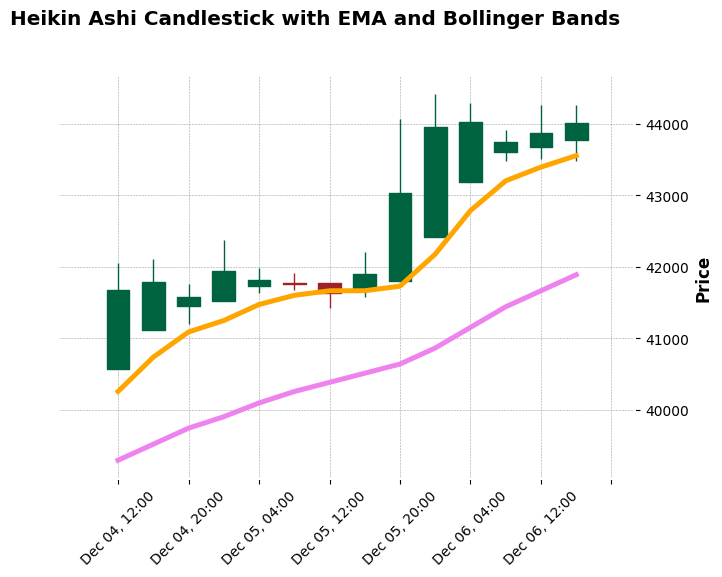

In [ ]:
plot_ha(bar=bar_df[1][0] )

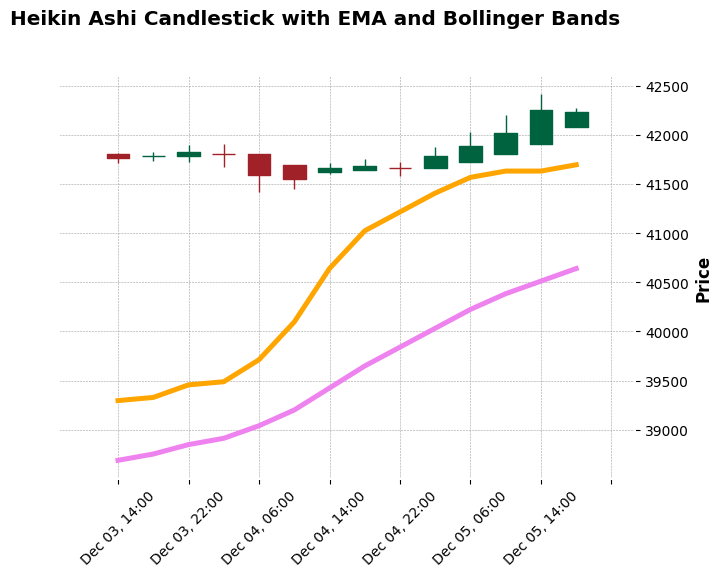

In [ ]:
plot_ha(bar=df)

In [ ]:
import mplfinance as mpf
import numpy as np
import pandas as pd

# Assuming 'bar' is a pandas DataFrame with OHLC data and the additional columns
# 'ha_open', 'ha_high', 'ha_low', 'ha_close', 'bb_upper', 'bb_lower', 'ema5', 'ema20'

# Create a list of plots for the additional lines (moving averages and Bollinger Bands)
def plot_ha(bar, ha_ohlc= True):

# Assuming 'dates', 'opens', 'highs', 'lows', 'closes' are your arrays
# Create a DataFrame
# bb_bands = [ [ lower_band[i], upper_band[i]] for i in range( len(lower_band) )]
#           bollinger_bands_list[symbol] = bb_bands

# Plot the DataFrame
    df = pd.DataFrame(index=pd.to_datetime(bar["index"]), data={'Open': bar["Open"] , 'High': bar["High"], 'Low': bar["Low"], 'Close': bar["Close"], \
                                'bb_upper':bar['bb_upper'] , 'bb_lower':bar['bb_lower'], 'ema5':bar['ema5'], 'ema20': bar['ema20']
                                ,'atr_upper':bar['atr_upper'] , 'atr_lower':bar['atr_lower']   })
    add_plots = [
        # mpf.make_addplot(df['bb_upper'], panel=0, color='yellow'),
        # mpf.make_addplot(df['bb_lower'], panel=0, color='yellow'),
        # mpf.make_addplot(df['atr_upper'], panel=0, color='yellow'),
        # mpf.make_addplot(df['atr_lower'], panel=0, color='yellow'),

        mpf.make_addplot(df['ema5'], panel=0, color='orange'),
        mpf.make_addplot(df['ema20'], panel=0, color='violet')
    ]

    # Create the Heikin Ashi candlestick plot
    mpf.plot(df, type='candle', style='charles',
            title='Heikin Ashi Candlestick with EMA and Bollinger Bands',
            ylabel='Price',
            addplot=add_plots)


In [ ]:
!pip install mplfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 731.6 kB/s eta 0:00:00


In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

def heikin_ashi_candles_plot(bar):
    fig = make_subplots(rows=2, cols=1)
    fig= go.Figure(data= [go.Candlestick(x=bar["index"] , open=bar["Open"]
        ,high=bar["High"] , low=bar["Low"]  ,close=bar["Close"] )])


    fig.add_scatter( name="upper_band" ,x=bar["index"]  , y=bar['bb_upper'], mode='lines' , line=dict(color='yellow', width=1.5))

    fig.add_scatter( name="lower_band" ,x=bar["index"]  , y=bar['bb_lower'], mode='lines' , line=dict(color='yellow', width=1.5))

# fig.add_scatter( name="upper_band" ,x=bar["index"]  , y=bar['atr_upper'], mode='lines' , line=dict(color='yellow', width=1.5))

#     fig.add_scatter( name="lower_band" ,x=bar["index"]  , y=bar['atr_lower'], mode='lines' , line=dict(color='yellow', width=1.5))


    fig.add_scatter( name="EMA-5-period" ,x=bar["index"]  , y=bar['ema5'],   mode='lines' , line=dict(color='orange', width=2.5))
    fig.add_scatter( name="EMA-20-period" ,x=bar["index"]  , y=bar['ema20'], mode='lines' , line=dict(color='violet', width=2.5))


    # fig.add_scatter( name="Average_True_Range" , x=bars.index.values  , y=bars['Average_True_Range'], mode='lines' , line=dict(color='yellow', width=1.5) )
    fig.update_layout(yaxis_tickformat = ".5f")
    # yaxis="tickformat': 5.f" )
                      # {'tickformat': '5.f'})


    fig.update_layout(plot_bgcolor='rgb(8, 14, 44)')
    fig.update_xaxes(showline=True, linewidth=2, linecolor='white' , gridcolor='rgb(8, 14, 44)')
    fig.update_yaxes(showline=True, linewidth=2, linecolor='white' , gridcolor='grey')
    # fig.update_layout(title=f'{title}')
    fig.show()

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
"""
## Example
bar = yfinance or inclusive bar["High"]  bar["Low"] bar["Close"]
plot_candles_atr(bar , index=None   )

"""



def plot_candles_atr(bar , index=None):
  fig = make_subplots(rows=2, cols=1)
  fig= go.Figure(data= [go.Candlestick(x=bar.index.values if not index else bar.index.values[index:], open=bar["Open"] if not index else bar["Open"][index:]
      ,high=bar["High"] if not index else bar["High"][index:] , low=bar["Low"] if not index else bar["Low"][index:]  ,close=bar["Close"] if not index else bar["Close"][index:])])


  fig.add_scatter( name="upper_band" ,x=bar.index.values  , y=bar['upper_band'], mode='lines' , line=dict(color='yellow', width=1.5))

  fig.add_scatter( name="lower_band" ,x=bar.index.values  , y=bar['lower_band'], mode='lines' , line=dict(color='yellow', width=1.5))


  # fig.add_scatter( name="Average_True_Range" , x=bars.index.values  , y=bars['Average_True_Range'], mode='lines' , line=dict(color='yellow', width=1.5) )
  fig.update_layout(yaxis_tickformat = ".5f")
  # yaxis="tickformat': 5.f" )
                    # {'tickformat': '5.f'})


  fig.update_layout(plot_bgcolor='rgb(8, 14, 44)')
  fig.update_xaxes(showline=True, linewidth=2, linecolor='white' , gridcolor='rgb(8, 14, 44)')
  fig.update_yaxes(showline=True, linewidth=2, linecolor='white' , gridcolor='grey')
  # fig.update_layout(title=f'{title}')
  fig.show()

# Testing

In [ ]:
class MyClass:
  # Declare a class attribute
  global_var = 100

  def func1(cls):
    # Access and modify the class attribute
    print(f"Global variable in func1: {MyClass.global_var}")
    MyClass.global_var += 1

  def func2(cls):
    # Access the class attribute
    print(f"Global variable in func2: {MyClass.global_var}")
    MyClass.global_var += 2

obj = MyClass()
obj.func1()   # Prints "Global variable in func1: 10"
obj.func2()   # Prints "Global variable in func2: 11"
print(MyClass.global_var)  # Prints "Global variable outside class: 13"


Global variable in func1: 100
Global variable in func2: 101
103


In [ ]:
import numpy as np

# Create a sample structured array
data = np.array([(1, 'John', 22),
                 (2, 'Alice', 30),
                 (3, 'Bob', 18),
                 (4, 'Charlie', 28),
                 (5, 'David', 25)],
                dtype=[('id', int), ('name', 'U10'), ('age', int)])

# Create a boolean mask based on the condition (age less than 25)

observe = data[-3:]

mask    = observe['age'] < 25

# Apply the mask to filter the array

filtered_data = observe[mask]

# Get the last three rows with the most recent indices
# last_three_rows = filtered_data[-3:]

# print(last_three_rows)
print(len(filtered_data))
# mask

1


# Archive

In [ ]:
"""
bar_df = indicators_lookback_mode.transform_data_list( refine_list = refined_list, multiplier= 1.7 , atr_period = 5,  adx_period = 8 ,   lookback = 1  )
print(bar_df)

"""

class  indicators_lookback_mode( access_indicators ):

  @classmethod
  def transform_data_list(cls, refine_list ,  multiplier= 1.7 , atr_period = 5,  adx_period = 8,   lookback = 10  ):

    symbols  = 0
    values   = 1

    indicator = cls() # universal class of project => adx_indicator

    # crossover_direction_list  =  adx_atr_bands_indicator.crossover_direction_lookback(bar_list = refine_list, lookback = lookback )


    crossover_direction_list  =  indicator.crossover_direction_lookback_forex(bar_list = refine_list, lookback = lookback )

    emaz_list  =  indicator.ema_lookback( bar_list = refine_list, lookback = lookback )

    atr_bands_list = indicator.atr_bands_lookback( refine_list , multiplier,  period = atr_period ,  lookback = lookback  )

    adx_value_list = indicator.adx_lookback( bar_list = refine_list,   period = adx_period , lookback = lookback)

    ha_status_list = indicator.get_heikin_ashi ( bar_list, lookback = lookback)
    fractal_status_list = indicator.get_fractal( bar_list, lookback = lookback)


    # lookback = 10

    dt   = np.dtype([ ('index', 'datetime64[h]'),  ('symbol', 'U20'), ('Close', float ), ('Fractal-Status', 'U10'), ('Heikin-Ashi-Status', 'U10'),  ('Direction', float), ('Average-Directional-Index', float), ('Crossover', float),   \
                     ('Stop_Loss', float), ('Take_Profit', float) ,  ('ema20', float), ('ema5', float)  ])

    column_names = dt.names
    data = [[0]]  * len(refine_list[symbols])


    for sym , ohlc in enumerate(refine_list[values]):

            index  = ohlc['index'][-lookback:]
            symbol = ohlc['symbol'][-lookback:]
            close  = ohlc['Close'][-lookback:]

            heikin_ashi_status = [  element    for  element in ha_status_list[sym]  ]

            fractal_status  = [ element  for  element in fractal_status_list[sym]  ]

            adx_value  = [  element    for  element in adx_value_list[sym]  ]
            lower_band = [  element[0] for  element in atr_bands_list[sym]  ]
            upper_band = [  element[1] for  element in atr_bands_list[sym]  ]


            # crossover =   crossover_direction_list[index][dynamic--for next values of crossover of date time index][0-->static for crossover]

            crossover = [ element[0] for  element in crossover_direction_list[sym] ]
            direction = [ element[1] for  element in crossover_direction_list[sym] ]

            ema20 = [ element[0] for  element in  emaz_list[sym] ]

            ema5  = [ element[1] for  element in  emaz_list[sym] ]

            # return [ adx_value, [lower_band, upper_band ], [crossover,direction ] ]

            ohlc_df = np.empty(len(close), dtype=dt)

            for i in range(0 , len(ohlc_df)):

                stop_loss   =  take_profit =  0
                if crossover[i] == 1  or  direction[i] == 1 :
                      stop_loss   = lower_band[i]
                      take_profit = upper_band[i]

                elif crossover[i] == -1  or  direction[i] == -1 :
                      stop_loss   = upper_band[i]
                      take_profit = lower_band[i]

                ohlc_df[i] = ( index[i], symbol[i], close[i], fractal_status[i] , heikin_ashi_status[i], direction[i], adx_value[i], \
                               crossover[i], stop_loss, take_profit ,  ema20[i], ema5[i]   )


            data[sym] = ohlc_df

    return [column_names, data]


In [ ]:
class heikin_ashi (adx_indicator):

  def __init__(self, refine_list = None):

      self.refine_list = refine_list

  def run_heikin_ashi(self, refine_list ):

      ha_status_list = self.get_heikin_ashi(self, bar_list )

      return  ha_status_list

  def heikin_ashi_status(self, ha_open , ha_close ):

      candles =  np.full_like( ha_close, '', dtype='U10')

      for i in range(1 , len(ha_close) ):

            # green_condition =  ha_close[i] > ha_open[i]
            # red_condition   =  ha_close[i] < ha_open[i]
            if ha_close[i] > ha_open[i] :
              candles[i]  = 'Green'

            elif ha_close[i] < ha_open[i] :
              candles[i]  = 'Red'

            else:
              candles[i] = 'Neutral'

      return  candles


  def heikin_ashi_candles (self, open, high, low, close ):

      ha_close =  np.empty(len(close), dtype=np.float32 )

      ha_high = np.empty(len(close), dtype=np.float32 )
      ha_low  = np.empty(len(close), dtype=np.float32 )
      ha_open = np.empty(len(close), dtype=np.float32 )

      # candles =  np.empty(len(close) , dtype='U10')
      # candles = [[]] *  len(close) , dtype=np.int16

      ha_open[0]  = (open[0] + close[0] ) /2
      ha_close[0] = (close[0] + open[0] + high[0] + low[0]) /4

      for i in range(1 , len(close) ):
            ha_open[i]  = (ha_open[i-1] + ha_close[i-1] ) / 2
            ha_close[i] = (open[i] +  high[i] + low[i] + close[i]) / 4
            ha_high[i]  = max( high[i], ha_open[i], ha_close[i]  )
            ha_low[i]   = min( low[i], ha_open[i], ha_close[i]  )

      return   ha_open, ha_close, ha_high, ha_low


  def get_heikin_ashi (self, bar_list, lookback = None, ohlc_data=None ):

      symbols  = 0
      values   = 1
      ha_status_list = [[]] * len(bar_list[symbols])
      ha_ohlc_list   = [[]] * len(bar_list[values])
      # np.empty(len(bar_list[symbols]), dtype='U10')

      for  symbol , ohlc in enumerate(bar_list[values]):

          open, high,  low, close  = ohlc['Open'],  ohlc['High'],  ohlc['Low'], ohlc['Close']

          ha_open, ha_close, ha_high, ha_low   =  self.heikin_ashi_candles( open, high, low, close )
          candles  =  self.heikin_ashi_status(ha_open , ha_close)

          if lookback :
            candles  =  candles[-lookback:]
            ha_open, ha_close, ha_high, ha_low = ha_open[-lookback:], ha_close[-lookback:], ha_high[-lookback:], ha_low[-lookback:]
            # ha_open_close  = [ ha_open[-lookback:] , ha_close[-lookback:] ]


          ha_ohlc_list[symbol]   =  [ha_open, ha_close, ha_high, ha_low]
          ha_status_list[symbol] = candles

      if  ohlc_data == 'True' :

          return ha_ohlc_list

      return ha_status_list

In [ ]:
basis = sma(source, length)
dev = mult * stdev(source, length)
upperBB = basis + dev
lowerBB = basis - dev

In [ ]:
class bollinger_bands:

  def __init__(self, refine_list = None):

      self.refine_list = refine_list

  def sma (self, array, period ):

       sma = np.empty_like(array)
       sma = np.full( sma.shape , np.nan)
       sma[0] = np.mean(array[0] , dtype=np.float16)
       alpha = 1 / period
        # Calculate the EMA for each window of 14 values
       for i in range(1 , len(array) ):
              sma[i] = np.array( (array[i] * alpha +  sma[i-1]  * (1-alpha) ) , dtype=np.float16 )
       return sma

  def std (self, array, sma_array, period ):

       std = np.empty_like(array)
       std = np.full( sma.shape , np.nan)
       std[0] = array[0] - sma_array[0]
       alpha = 1 / period
        # Calculate the EMA for each window of 14 values
       for i in range(1 , len(array) ):
              std[i] = np.array( (array[i] * alpha +  std[i-1]  * (1-alpha) ) , dtype=np.float16 )
       return std

  def run_bollinger_bands(self, refine_list ):

      bollinger_bands_list = self.get_bollinger_bands(self, bar_list )
      return  bollinger_bands_list

  def bollinger_bands(self , high, low, close  ):

      # bollinger_bands
      period = 20
      k  =  2.0
      upper_band =  np.empty(len(close), dtype=np.float32 )

      lower_band    = np.empty(len(close), dtype=np.float32 )
      typical_price =  (high + low + close) / 3
      typical_price_ma  = self.sma(typical_price, period )
      diff = (typical_price - typical_price_ma)
      sd = np.sqrt( diff** 2 /period )
      typical_price_std = np.empty(len(close), dtype=np.float32 )

      upper_band = typical_price_ma + (k * sd )
      lower_band = typical_price_ma - (k * sd )

      return lower_band , upper_band


  def get_bollinger_bands (self, bar_list, lookback = None ):

      symbols  = 0
      values   = 1
      bollinger_bands_list   = [[]] * len(bar_list[values])
      # np.empty(len(bar_list[symbols]), dtype='U10')

      for  symbol , ohlc in enumerate(bar_list[values]):

          high,  low,   close      =   ohlc['High'],  ohlc['Low'],  ohlc['Close']
          lower_band , upper_band  =  self.bollinger_bands( high, low, close )

          if lookback :
            lower_band , upper_band    =  lower_band[-lookback:],  upper_band[-lookback:]

          bollinger_bands_list[symbol] =  [lower_band , upper_band]

      return bollinger_bands_list




In [ ]:
import yfinance as yf

def get_data(symbols , interval = None , period = None):
    # symbols = ['BTC-USD' , 'ETH-USD' ]
    if interval == None and period == None :
      interval = '5m'
      period = '1d'

    data = [[0]]  * len(symbols)

    for i , symbol in  enumerate(symbols):
      bar = yf.download(tickers=f'{symbol}' , interval=f'{interval}' , period=f'{period}' )
      data[i] =  bar

    bar_list  = [ symbols , data ]

    symbols = 0  # index 0 for symbols
    values  = 1  # index 1 for ohlc

    return  bar_list

In [ ]:
symbols = ['BTC-USD' , 'ETH-USD' ]
bar_list = get_data(symbols , interval = '1H' , period = '7d' )


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
bar_list[1]

[                             Open          High           Low         Close  \
 Datetime                                                                      
 2023-11-27 00:00:00  37454.191406  37545.757812  37397.285156  37495.140625   
 2023-11-27 01:00:00  37495.527344  37559.355469  37480.632812  37503.066406   
 2023-11-27 02:00:00  37504.199219  37504.199219  37247.308594  37305.535156   
 2023-11-27 03:00:00  37311.531250  37333.164062  37231.894531  37302.117188   
 2023-11-27 04:00:00  37309.085938  37386.128906  37273.750000  37386.128906   
 ...                           ...           ...           ...           ...   
 2023-12-01 15:00:00  38335.136719  38442.648438  38296.527344  38421.765625   
 2023-12-01 16:00:00  38420.769531  38954.109375  38417.679688  38841.156250   
 2023-12-01 17:00:00  38841.621094  38875.332031  38725.527344  38800.347656   
 2023-12-01 18:00:00  38802.671875  38861.691406  38738.742188  38738.742188   
 2023-12-01 19:00:00  38722.710938  3873

In [ ]:
symbols = ['BTC-USD=X' , 'ETH-USD=X' ]
# symbols = ['EURUSD=X']
# symbols = ['^GSPC']
symbols = ['^DJI']

bar_list = get_data(symbols , interval = '1H' , period = '5d' )



[*********************100%%**********************]  1 of 1 completed


In [ ]:
bar_list[1]

[                             Open          High           Low         Close  \
 Datetime                                                                      
 2023-11-27 09:30:00  35376.441406  35410.371094  35315.628906  35340.179688   
 2023-11-27 10:30:00  35340.089844  35357.578125  35306.000000  35340.519531   
 2023-11-27 11:30:00  35340.511719  35343.980469  35280.570312  35295.800781   
 2023-11-27 12:30:00  35296.199219  35331.941406  35289.429688  35327.070312   
 2023-11-27 13:30:00  35327.199219  35353.730469  35320.781250  35345.160156   
 2023-11-27 14:30:00  35344.910156  35346.371094  35293.738281  35340.519531   
 2023-11-27 15:30:00  35341.710938  35374.230469  35322.210938  35333.699219   
 2023-11-28 09:30:00  35332.128906  35369.960938  35307.730469  35358.351562   
 2023-11-28 10:30:00  35358.269531  35481.289062  35356.250000  35463.238281   
 2023-11-28 11:30:00  35463.761719  35518.671875  35455.949219  35461.488281   
 2023-11-28 12:30:00  35461.531250  3546

In [ ]:
import pandas as pd
import numpy as np
"""
## Example
bar = yfinance or inclusive bar["High"]  bar["Low"] bar["Close"]
avg_true_range    =   atr ( bar , period=14  )
"""
def sma (array, period ):

    sma = np.empty_like(array)
    sma = np.full( sma.shape , np.nan)
    # Calculate the EMA for each window of 14 values
    for i in range(period, len(array)+1 ):
          sma[i-1] = np.mean(array[i-period:i] , dtype=np.float16)
    return sma


def atr ( bars , period  ):

  high_low, high_close, low_close  = np.array(bars["High"]-bars["Low"],dtype=np.float16 ) ,
  np.array(abs(bars["High"]-bars["Close"].shift()),dtype=np.float16 ) ,
    np.array(abs(bars["Low"]-bars["Close"].shift() ),dtype=np.float16 )

  true_range = np.amax (np.hstack( (high_low, high_close, low_close) ).reshape(-1,3),axis=1 )
  avg_true_range = sma(true_range , period )  # takes average for 14 period
  return avg_true_range

# returning "true_range" is optional not needed.


def  atr_bands( bar , multiplier  , period ):

  close = np.array( bars["Close"] ,dtype=np.float16  )
  # multiplier = 2.0
  high_low, high_close, low_close  = np.array(bars["High"]-bars["Low"],dtype=np.float16 ) ,
  np.array(abs(bars["High"]-bars["Close"].shift()),dtype=np.float16 ) ,
    np.array(abs(bars["Low"]-bars["Close"].shift() ),dtype=np.float16 )

  true_range = np.amax (np.hstack( (high_low, high_close, low_close) ).reshape(-1,3),axis=1 )
  true_range = np.nan_to_num(true_range , nan=0)

  avg_true_range = sma(true_range , period )  # takes average for 14 period

  upper_band =   smoothed( close, 3)   + (multiplier * avg_true_range)
  lower_band =   smoothed( close, 3)   - (multiplier * avg_true_range)

  return  upper_band , lower_band

In [ ]:
!pip install plotly

In [ ]:
!pip install pandas

In [ ]:
import csv

# Specify the path to your CSV file
csv_file_path = 'BTC-USD.csv'

# Open the CSV file and read its contents
with open(csv_file_path, 'r', newline='', encoding='utf-8') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)

    # Iterate over rows in the CSV file
    for row in csv_reader:
        # Each row is a list representing the values in that row
        print(row)


['{"index":{"0":1701280800000', '1:1701295200000', '2:1701309600000', '3:1701324000000', '4:1701338400000', '5:1701352800000', '6:1701367200000', '7:1701381600000', '8:1701396000000', '9:1701410400000', '10:1701424800000', '11:1701439200000', '12:1701453600000', '13:1701468000000}', 'symbol:{"0":"BTC-USD"', '1:"BTC-USD"', '2:"BTC-USD"', '3:"BTC-USD"', '4:"BTC-USD"', '5:"BTC-USD"', '6:"BTC-USD"', '7:"BTC-USD"', '8:"BTC-USD"', '9:"BTC-USD"', '10:"BTC-USD"', '11:"BTC-USD"', '12:"BTC-USD"', '13:"BTC-USD"}', 'heikin-ashi-ohlc:{"0":[38129.6015625', '38346.13671875', '38129.6015625', '38258.6953125]', '1:[38194.1484375', '38338.4765625', '38194.1484375', '38285.1640625]', '2:[38239.65625', '38698.18359375', '38239.65625', '38511.9609375]', '3:[38375.80859375', '38820.18359375', '38375.80859375', '38658.5390625]', '4:[38517.171875', '38658.2578125', '38517.171875', '38579.4296875]', '5:[38548.30078125', '38621.00390625', '38324.87890625', '38478.53125]', '6:[38513.4140625', '38513.4140625', '3

In [ ]:
import pandas as pd
import numpy as np

# Read CSV file into a pandas DataFrame
csv_file_path = 'BTC-USD.csv'
# df = pd.read_csv(csv_file_path)

# # Convert pandas DataFrame to NumPy structured array
# structured_array = df.to_records(index=False)

# # Now structured_array is a NumPy structured array containing the data from the CSV file
# print(structured_array)


# Read CSV file without specifying index or columns
df = pd.read_csv(csv_file_path)
# df = df.transpose()

# If you want to reset the index
# df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(df)



Empty DataFrame
Columns: [{"index":{"0":1701280800000, 1:1701295200000, 2:1701309600000, 3:1701324000000, 4:1701338400000, 5:1701352800000, 6:1701367200000, 7:1701381600000, 8:1701396000000, 9:1701410400000, 10:1701424800000, 11:1701439200000, 12:1701453600000, 13:1701468000000}, symbol:{"0":"BTC-USD", 1:"BTC-USD", 2:"BTC-USD", 3:"BTC-USD", 4:"BTC-USD", 5:"BTC-USD", 6:"BTC-USD", 7:"BTC-USD", 8:"BTC-USD", 9:"BTC-USD", 10:"BTC-USD", 11:"BTC-USD", 12:"BTC-USD", 13:"BTC-USD"}, heikin-ashi-ohlc:{"0":[38129.6015625, 38346.13671875, 38129.6015625, 38258.6953125], 1:[38194.1484375, 38338.4765625, 38194.1484375, 38285.1640625], 2:[38239.65625, 38698.18359375, 38239.65625, 38511.9609375], 3:[38375.80859375, 38820.18359375, 38375.80859375, 38658.5390625], 4:[38517.171875, 38658.2578125, 38517.171875, 38579.4296875], 5:[38548.30078125, 38621.00390625, 38324.87890625, 38478.53125], 6:[38513.4140625, 38513.4140625, 38321.828125, 38370.40625], 7:[38441.91015625, 38441.91015625, 38249.33984375, 38336.

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
"""
## Example
bar = yfinance or inclusive bar["High"]  bar["Low"] bar["Close"]
plot_candles_atr(bar , index=None   )

"""



def plot_candles_atr(bar , index=None):
  fig = make_subplots(rows=2, cols=1)
  fig= go.Figure(data= [go.Candlestick(x=bar.index.values if not index else bar.index.values[index:], open=bar["Open"] if not index else bar["Open"][index:]
      ,high=bar["High"] if not index else bar["High"][index:] , low=bar["Low"] if not index else bar["Low"][index:]  ,close=bar["Close"] if not index else bar["Close"][index:])])


  fig.add_scatter( name="upper_band" ,x=bar.index.values  , y=bar['upper_band'], mode='lines' , line=dict(color='yellow', width=1.5))

  fig.add_scatter( name="lower_band" ,x=bar.index.values  , y=bar['lower_band'], mode='lines' , line=dict(color='yellow', width=1.5))


  # fig.add_scatter( name="Average_True_Range" , x=bars.index.values  , y=bars['Average_True_Range'], mode='lines' , line=dict(color='yellow', width=1.5) )
  fig.update_layout(yaxis_tickformat = ".5f")
  # yaxis="tickformat': 5.f" )
                    # {'tickformat': '5.f'})


  fig.update_layout(plot_bgcolor='rgb(8, 14, 44)')
  fig.update_xaxes(showline=True, linewidth=2, linecolor='white' , gridcolor='rgb(8, 14, 44)')
  fig.update_yaxes(showline=True, linewidth=2, linecolor='white' , gridcolor='grey')
  # fig.update_layout(title=f'{title}')
  fig.show()